In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter
import seaborn as sns
import locale

csv_folder_path = "D:/airline_csvs/"

In [19]:
# display settings (user preference)

# global setting: impacts formatting of decimals and thousands-separators as well as visualization language
language_setting = "de"     # "de" for German, "en" for English


def set_display_locale(lang):
    if lang == "en":
        locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
        def fmt(x):
            if abs(x) < 1000:
                return f"{x:,.2f}"
            else:
                return f"{x:,.0f}"
    elif lang == "de":
        locale.setlocale(locale.LC_ALL, "de_DE.UTF-8")
        def fmt(x):
            if abs(x) < 1000:
                return locale.format_string("%.2f", x, grouping=True)
            else:
                return locale.format_string("%.0f", x, grouping=True)
    else:
        raise ValueError("lang must be 'en' or 'de'")

    pd.options.display.float_format = fmt


set_display_locale(language_setting)
#pd.reset_option("display.float_format")

save_location_eng = "visualizations_eng/"
save_location_ger = "visualizations_ger/"

path = [save_location_ger if language_setting == "de" else save_location_eng][0]

## Get Tables

In [3]:
df_airports = pd.read_csv(csv_folder_path + "airports.csv", sep=";", decimal=",")
df_aircraft = pd.read_csv(csv_folder_path + "aircraft.csv", sep=";", decimal=",")
df_routes = pd.read_csv(csv_folder_path + "routes.csv", sep=";", decimal=",")

In [4]:
df_freq_flyer_discounts = pd.read_csv(csv_folder_path + "frequent_flyer_discounts.csv", sep=";", decimal=",")
df_freq_flyer_discounts["frequent_flyer_discount"] = df_freq_flyer_discounts["frequent_flyer_discount"] * 100
df_freq_flyer_discounts.rename(columns={"frequent_flyer_discount": "frequent_flyer_discount_pct"}, inplace=True)

In [5]:
df_weather = pd.read_csv(f"{csv_folder_path}weather.csv", parse_dates=["observation_time"], sep=";", decimal=",")

In [6]:
df_flights = pd.read_csv(
    f"{csv_folder_path}flights_booked_passengers.csv",
    parse_dates=["flight_date", "scheduled_departure", "scheduled_arrival", "actual_departure", "actual_arrival"],
    sep=";", decimal=","
)

In [7]:
df_costs_per_flight = pd.read_csv(csv_folder_path + "costs_per_flight.csv", sep=";", decimal=",")
df_flight_capacity_by_class = pd.read_csv(csv_folder_path + "flight_capacity_by_class.csv", sep=";", decimal=",")
df_flight_class_cost_shares = pd.read_csv(csv_folder_path + "flight_class_cost_shares.csv", sep=";", decimal=",")

In [8]:
df_bookings = pd.read_csv(
    csv_folder_path + "bookings.csv", parse_dates=["flight_date", "booking_time"], sep=";", decimal=","
)

In [9]:
df_customers = pd.read_csv(
    csv_folder_path + "customers_cleaned.csv", parse_dates=["date_of_birth"], dtype={"phone": "object"}, sep=";", decimal=",")
df_customers = df_customers.sort_values("customer_id")

## Cohort Analysis

In [13]:
df_cohorts = (
    df_bookings.query("booking_time >= '2021-10-01'")
    [["booking_time", "customer_id", "price_paid", "flight_cxl_refund"]].copy()
)

# get time of the first booking for each customer
first_bookings = df_cohorts.groupby("customer_id")["booking_time"].min().rename("first_booking")
df_cohorts = df_cohorts.merge(first_bookings, on="customer_id")

# extract quarters from all booking times and from first bookings
df_cohorts["booking_quarter"] = df_cohorts["booking_time"].dt.to_period("Q")
df_cohorts["cohort_quarter"] = df_cohorts["first_booking"].dt.to_period("Q")

# remove redundant columns
df_cohorts = df_cohorts.drop(columns=["booking_time", "first_booking"])

# calculate customer retention times in quarters
df_cohorts["quarters_since_first_booking"] = (
    (df_cohorts["booking_quarter"] - df_cohorts["cohort_quarter"]).apply(lambda x: x.n))

# clean format
df_cohorts["cohort_quarter"] = df_cohorts["cohort_quarter"].dt.strftime("%Y Q%q")

#df_cohorts

In [14]:
df_cohorts_grouped = (
    df_cohorts.query("flight_cxl_refund == False")
    .groupby("cohort_quarter").agg(
        unique_customer_count=("customer_id", "nunique"),
        avg_retention_time_quarters=("quarters_since_first_booking", "mean"),
        total_ltv=("price_paid", "sum"),
        average_ltv=("price_paid", "mean")
    )
)

df_cohorts_grouped = df_cohorts_grouped.drop(index="2024 Q4")

df_cohorts_grouped

,unique_customer_count,avg_retention_time_quarters,total_ltv,average_ltv
cohort_quarter,,,,
2021 Q4,1562423,"4,57",2.030.827.121,"340,31"
2022 Q1,2577424,"3,98",3.090.761.035,"336,62"
2022 Q2,2203219,"3,52",2.458.183.184,"335,47"
2022 Q3,1605687,"3,10",1.671.809.884,"339,42"
2022 Q4,1224664,"2,64",1.189.079.837,"340,01"
2023 Q1,963006,"2,20",863.061.067,"340,04"
2023 Q2,826843,"1,77",668.902.498,"336,88"
2023 Q3,599922,"1,39",442.927.546,"342,99"
2023 Q4,455364,"1,00",302.971.426,"343,89"


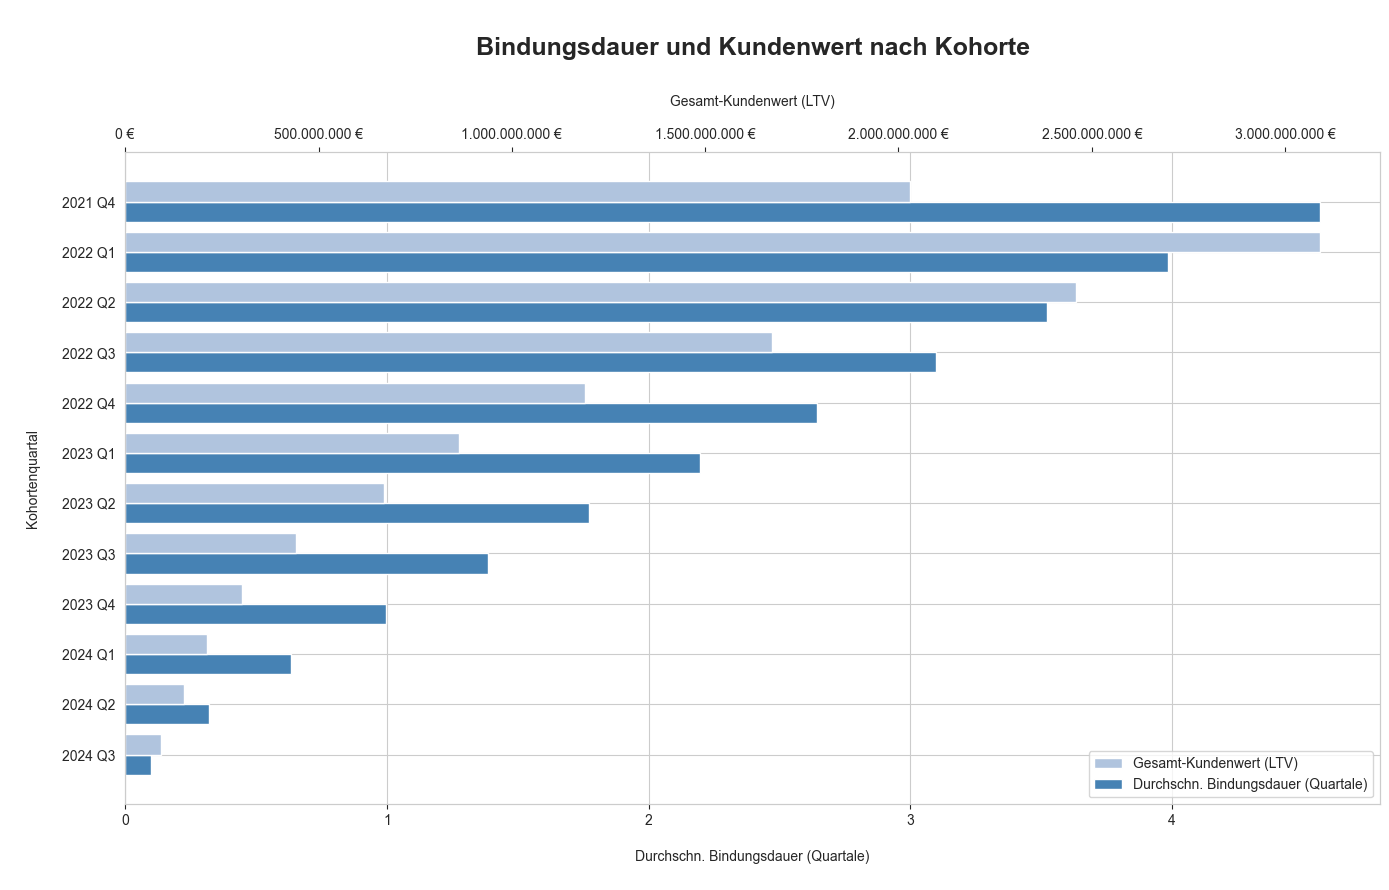

In [715]:
# plot Avg Retention Time & Total/Average LTV by Cohort

# choose LTV to plot:
ltv_setting = "total"   # "total" or "average"

annotations_english = {
    "title": "Retention Time & LTV by Cohort",
    "y_label": "Cohort Quarter",
    "x1_label": "Avg Retention (Quarters)",
    "x2a_label": "Total LTV",
    "x2b_label": "Average LTV",
    "file": "(01)_cohorts_retention_ltv"
}

annotations_german = {
    "title": "Bindungsdauer und Kundenwert nach Kohorte",
    "y_label": "Kohortenquartal",
    "x1_label": "Durchschn. Bindungsdauer (Quartale)",
    "x2a_label": "Gesamt-Kundenwert (LTV)",
    "x2b_label": "Durchschn. Kundenwert (LTV)",
    "file": "(01)_kohorten_bindung_wert"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

if ltv_setting == "total":
    ltv_column = "total_ltv"
    ltv_label = annot["x2a_label"]
elif ltv_setting == "average":
    ltv_column = "average_ltv"
    ltv_label = annot["x2b_label"]
else:
    raise ValueError("Invalid ltv_setting value. Must be 'total' or 'average'.")

# group by retention time for plotting
df_cohorts_grouped = df_cohorts_grouped.sort_values(by="avg_retention_time_quarters")

# plot
fig, ax1 = plt.subplots(figsize=(14,9))
ax2 = ax1.twiny()

y = np.arange(len(df_cohorts_grouped))
height = 0.4

# bar 1
ax1.barh(y - height/2, df_cohorts_grouped["avg_retention_time_quarters"],
         height=height, color="steelblue", label=annot["x1_label"])

# bar 2
ax2.barh(y + height/2, df_cohorts_grouped[ltv_column],
         height=height, color="lightsteelblue", label=ltv_label)

# y labels
ax1.set_yticks(y)
ax1.set_yticklabels(df_cohorts_grouped.index)

# x labels
ax1.set_xlabel(f"\n{annot["x1_label"]}\n")
ax2.set_xlabel(f"\n\n{ltv_label}\n")
ax2.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: locale.format_string("%.0f", x, grouping=True) + " €")
)
ax1.set_ylabel(f"\n{annot["y_label"]}\n")
ax1.set_title(f"\n{annot["title"]}", fontsize=18, fontweight="bold")

ax2.grid(False)

# legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines2 + lines1, labels2 + labels1, loc="lower right")

plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
# get the number of unique customers per cohort
cohort_sizes = df_cohorts.groupby("cohort_quarter")["customer_id"].nunique().rename("unique_customer_count")

# get the number of retained customers per cohort
df_cohort_retention = (
    df_cohorts.groupby(["cohort_quarter", "quarters_since_first_booking"])["customer_id"].nunique()
    .rename("active_customer_count").reset_index()
    .merge(cohort_sizes, on="cohort_quarter")
)

# calculate retention rates
df_cohort_retention["retention_rate"] = (
    df_cohort_retention["active_customer_count"] / df_cohort_retention["unique_customer_count"]
)

#df_cohort_retention

In [17]:
# convert to matrix
cohort_retention_matrix = (
    df_cohort_retention.pivot(index="cohort_quarter", columns="quarters_since_first_booking", values="retention_rate")
    .drop(columns=0, index="2024 Q4")
)

cohort_retention_matrix

quarters_since_first_booking,1,2,3,4,5,6,7,8,9,10,11,12
cohort_quarter,,,,,,,,,,,,
2021 Q4,"0,22","0,24","0,22","0,22","0,22","0,24","0,22","0,22","0,22","0,24","0,22","0,11"
2022 Q1,"0,23","0,22","0,21","0,21","0,23","0,22","0,21","0,21","0,23","0,22","0,11",NaN
2022 Q2,"0,22","0,21","0,21","0,23","0,22","0,21","0,21","0,23","0,22","0,11",NaN,NaN
2022 Q3,"0,21","0,21","0,23","0,22","0,21","0,21","0,23","0,22","0,11",NaN,NaN,NaN
2022 Q4,"0,21","0,23","0,22","0,21","0,21","0,23","0,22","0,11",NaN,NaN,NaN,NaN
2023 Q1,"0,23","0,22","0,21","0,21","0,23","0,22","0,11",NaN,NaN,NaN,NaN,NaN
2023 Q2,"0,22","0,21","0,21","0,23","0,22","0,11",NaN,NaN,NaN,NaN,NaN,NaN
2023 Q3,"0,21","0,21","0,23","0,22","0,11",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023 Q4,"0,21","0,23","0,22","0,11",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


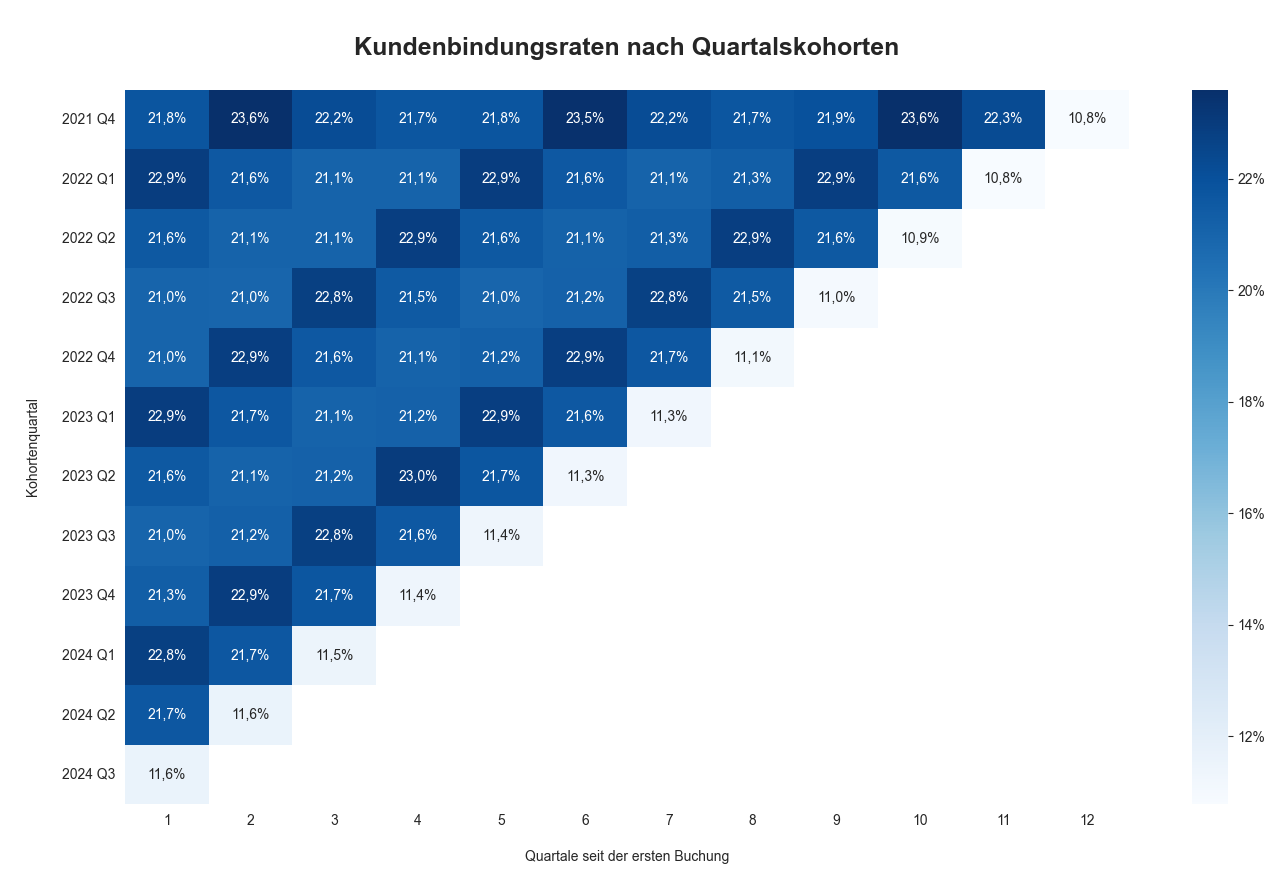

In [716]:
# plot retention matrix

annotations_english = {
    "title": "Customer Retention Rates by Quarterly Cohorts",
    "y_label": "Cohort Quarter",
    "x_label": "Quarters Since First Booking",
    "file": "(02)_cohort_retention_rates"
}

annotations_german = {
    "title": "Kundenbindungsraten nach Quartalskohorten",
    "y_label": "Kohortenquartal",
    "x_label": "Quartale seit der ersten Buchung",
    "file": "(02)_kohorten_bindungsraten"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

# Create formatted cell labels for annotations
cell_labels = cohort_retention_matrix.copy().map(
    lambda v_: locale.format_string("%.1f", v_ * 100, grouping=True) + "%" if pd.notna(v_) else ""
)

# plot
plt.figure(figsize=(14, 9))
ax = sns.heatmap(cohort_retention_matrix, annot=cell_labels, fmt="", cmap="Blues", cbar=True)

# format colorbar percentages
ax.collections[0].colorbar.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0, symbol="%"))

ax.grid(False)

plt.title(f"\n{annot["title"]}\n", fontsize=18, fontweight="bold")
plt.ylabel(f"\n{annot["y_label"]}\n")
plt.xlabel(f"\n{annot["x_label"]}\n")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

## Passenger Class Profitability

In [11]:
# calculate revenue per flight and cabin class, excluding canceled flights
class_revenues_per_flight = (
    df_bookings.query("flight_cxl_refund == False")
    .groupby(["flight_number", "class_name"])
    .agg(class_revenue=("price_paid", "sum")).reset_index()
)

class_profits_per_flight = df_flight_capacity_by_class.merge(class_revenues_per_flight, on=["flight_number", "class_name"])

# get class cost shares
class_costs_per_flight = (
    df_flight_capacity_by_class[["flight_number", "class_name"]]
    .merge(df_flight_class_cost_shares[["flight_number", "class_name", "cost_share"]],
    on=["flight_number", "class_name"])
)

# get costs per flight
class_costs_per_flight = class_costs_per_flight.merge(df_costs_per_flight[["flight_number", "flight_cost_total"]], on=["flight_number"])

# calculate class costs per flight
class_costs_per_flight["class_cost"] = class_costs_per_flight["flight_cost_total"] * class_costs_per_flight["cost_share"]

# calculate class profits per flight
class_profits_per_flight = class_profits_per_flight.merge(class_costs_per_flight[["flight_number", "class_name", "class_cost"]], on=["flight_number", "class_name"])
class_profits_per_flight["class_profit"] = class_profits_per_flight["class_revenue"] - class_profits_per_flight["class_cost"]

# calculate profit margins (%) per flight
class_profits_per_flight["class_profit_margin_pct"] = class_profits_per_flight["class_profit"] / class_profits_per_flight["class_revenue"] * 100

df_class_profits = class_profits_per_flight.copy()
df_class_profits

,flight_number,flight_date,class_name,capacity,class_bookings,class_revenue,class_cost,class_profit,class_profit_margin_pct
0,FL1000000,2022-01-01,Economy,130,76,2.598,3.258,"-660,22","-25,42"
1,FL1000000,2022-01-01,Business,15,14,1.207,"866,01","340,68","28,23"
2,FL1000001,2022-01-01,Economy,130,81,2.974,3.494,"-520,81","-17,51"
3,FL1000001,2022-01-01,Business,15,13,1.178,"928,88","249,49","21,17"
4,FL1000002,2022-01-01,Economy,130,72,11.807,14.545,-2.737,"-23,18"
...,...,...,...,...,...,...,...,...,...
556012,FL1289342,2024-12-31,Business,63,54,159.338,140.324,19.014,"11,93"
556013,FL1289342,2024-12-31,First,17,15,91.966,61.392,30.574,"33,25"
556014,FL1289343,2024-12-31,Economy,237,180,120.130,130.304,-10.174,"-8,47"
556015,FL1289343,2024-12-31,Business,63,54,95.620,77.217,18.402,"19,25"


In [13]:
# assign profit tiers, group by class and tier

class_names = ["Economy", "Business", "First"]
class_names_ordered = ["(1) Economy", "(2) Business", "(3) First"]

df_class_profits["class_name"] = df_class_profits["class_name"].replace(class_names, class_names_ordered)

profit_margin = df_class_profits["class_profit_margin_pct"]

profit_margin_ranges = [
    (profit_margin >= 30),
    (profit_margin.between(20, 30)),
    (profit_margin.between(10, 20)),
    (profit_margin.between(0, 10)),
    (profit_margin.between(-20, 0)),
    (profit_margin < -20),
]

profit_margin_tiers_eng = [
    "(1) Top Margin\n (≥ 30%)",
    "(2) High Margin\n (20% to 30%)",
    "(3) Moderate Margin\n (10% to 20%)",
    "(4) Low Margin\n (0% to 10%)",
    "(5) Loss\n (−20% to 0%)",
    "(6) Heavy Loss\n (< −20%)",
]

profit_margin_tiers_ger = [
    "(1) Top Marge\n (≥ 30%)",
    "(2) Hohe Marge\n (20% to 30%)",
    "(3) Mittlere Marge\n (10% to 20%)",
    "(4) Kleine Marge\n (0% to 10%)",
    "(5) Verlust\n (−20% to 0%)",
    "(6) Hoher Verlust\n (< −20%)"
]

df_class_profits["profit_margin_tier_eng"] = np.select(profit_margin_ranges, profit_margin_tiers_eng, default="Unknown")
df_class_profits["profit_margin_tier_ger"] = np.select(profit_margin_ranges, profit_margin_tiers_ger, default="Unbekannt")

class_profit_tiers = df_class_profits.groupby(["class_name", "profit_margin_tier_eng", "profit_margin_tier_ger"]).agg(
    class_bookings=("class_bookings", "sum"),
    avg_profit_margin_pct=("class_profit_margin_pct", "mean"),
    avg_class_profit=("class_profit", "mean"),
    median_class_profit=("class_profit", "median"),
    min_class_profit=("class_profit", "min"),
    max_class_profit=("class_profit", "max"),
    std_class_profit=("class_profit", "std")
).reset_index()

class_profit_tiers.insert(4, "class_bookings_pct", class_profit_tiers["class_bookings"] / class_profit_tiers["class_bookings"].sum() * 100)

class_profit_tiers

,class_name,profit_margin_tier_eng,profit_margin_tier_ger,class_bookings,class_bookings_pct,avg_profit_margin_pct,avg_class_profit,median_class_profit,min_class_profit,max_class_profit,std_class_profit
0,(1) Economy,(1) Top Margin\n (≥ 30%),(1) Top Marge\n (≥ 30%),4803019,"12,30","36,48",8.940,6.128,"748,87",105.679,10.167
1,(1) Economy,(2) High Margin\n (20% to 30%),(2) Hohe Marge\n (20% to 30%),6772039,"17,35","24,42",8.713,4.179,"362,50",90.882,12.676
2,(1) Economy,(3) Moderate Margin\n (10% to 20%),(3) Mittlere Marge\n (10% to 20%),7512433,"19,24","15,19",4.799,2.673,"179,14",60.149,6.576
3,(1) Economy,(4) Low Margin\n (0% to 10%),(4) Kleine Marge\n (0% to 10%),5625346,"14,41","5,19",1.353,"667,67","0,03",25.823,2.152
4,(1) Economy,(5) Loss\n (−20% to 0%),(5) Verlust\n (−20% to 0%),6069494,"15,55","-9,85",-2.251,-1.315,-41.872,"-0,02",3.353
5,(1) Economy,(6) Heavy Loss\n (< −20%),(6) Hoher Verlust\n (< −20%),2677856,"6,86","-27,48",-7.052,-3.797,-115.536,"-372,14",9.922
6,(2) Business,(1) Top Margin\n (≥ 30%),(1) Top Marge\n (≥ 30%),1800569,"4,61","36,28",3.642,1.797,"224,11",68.164,6.548
7,(2) Business,(2) High Margin\n (20% to 30%),(2) Hohe Marge\n (20% to 30%),1958399,"5,02","25,20",3.764,1.541,"145,07",55.223,6.279
8,(2) Business,(3) Moderate Margin\n (10% to 20%),(3) Mittlere Marge\n (10% to 20%),1197402,"3,07","15,87",3.826,1.311,"70,51",35.571,5.583
9,(2) Business,(4) Low Margin\n (0% to 10%),(4) Kleine Marge\n (0% to 10%),278818,"0,71","6,38",1.635,"391,37","0,08",16.623,2.714


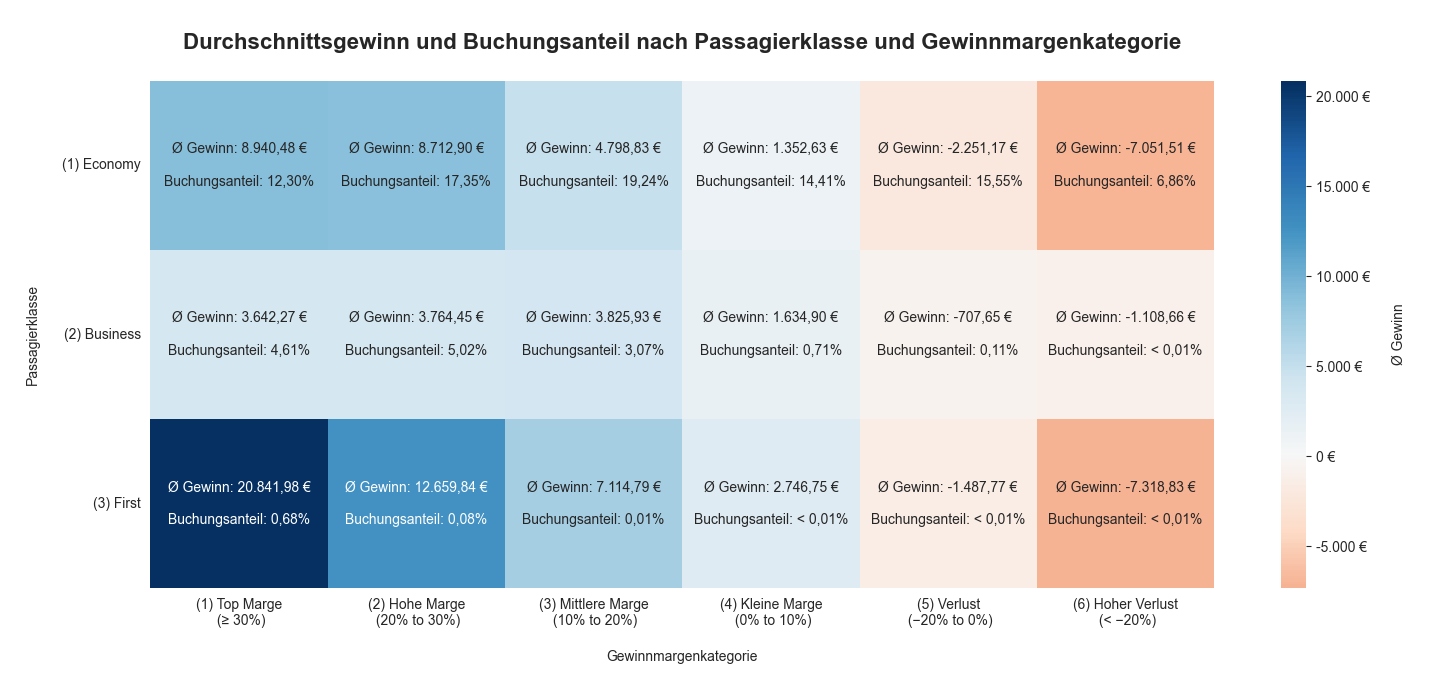

In [20]:
annotations_english = {
    "title": "Average Profit and Total Bookings Share by Passenger Class and Profit Margin Tier",
    "x_label": "Profit Margin Tier",
    "y_label": "Passenger Class",
    "tiers": "profit_margin_tier_eng",
    "flights_share": "Bookings Share",
    "avg_profit": "Avg Profit",
    "file": "(03)_class_profits"
}

annotations_german = {
    "title": "Durchschnittsgewinn und Buchungsanteil nach Passagierklasse und Gewinnmargenkategorie",
    "x_label": "Gewinnmargenkategorie",
    "y_label": "Passagierklasse",
    "tiers": "profit_margin_tier_ger",
    "flights_share": "Buchungsanteil",
    "avg_profit": "Ø Gewinn",
    "file": "(03)_passagierklasse_profite"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

# create two pivot tables for displaying both avg profits and flight counts heat map cells
color_values_pivot = class_profit_tiers.pivot(index="class_name", columns=annot["tiers"], values="avg_class_profit")
other_values_pivot = class_profit_tiers.pivot(index="class_name", columns=annot["tiers"], values="class_bookings_pct")

# combine cell annotations, include localized formatting
cell_annot = pd.DataFrame(index=other_values_pivot.index, columns=other_values_pivot.columns)
for row in cell_annot.index:
    for col in cell_annot.columns:
        profit = color_values_pivot.loc[row, col]
        flights = other_values_pivot.loc[row, col]
        if pd.notna(profit) and pd.notna(flights):
            if language_setting == "de":
                if flights < 0.005: flights_str = "< 0,01"
                else: flights_str = locale.format_string("%.2f", float(flights), grouping=True)
                profit_str = locale.format_string("%.2f", profit, grouping=True)
                cell_annot.loc[row, col] = f"{annot['avg_profit']}: {profit_str} €\n\n{annot['flights_share']}: {flights_str}%"
            else:
                if flights < 0.005: flights_str = "< 0.01"
                else: flights_str = f"{flights:,.2f}"
                cell_annot.loc[row, col] = f"{annot['avg_profit']}: {profit:,.0f} €\n\n{annot['flights_share']}: {flights_str}%"

# plot
plt.figure(figsize=(15, 7))
# use avg profits for coloring cells, combined annotations for cell values
ax = sns.heatmap(
    color_values_pivot, annot=cell_annot, fmt="", cmap="RdBu", center=0, cbar_kws={"label": "\n" + annot["avg_profit"] + "\n"})

# Format colorbar
ax.collections[0].colorbar.ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: locale.format_string("%d", int(x), grouping=True)+ " €")
)

plt.title(f"\n{annot["title"]}\n", fontsize=16, fontweight="bold")
plt.xlabel(f"\n{annot["x_label"]}\n")
plt.ylabel(f"\n{annot["y_label"]}\n")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

## Aircraft Utilization & Performance

In [22]:
# combine flights and aircraft tables, clarify column names
df_aircraft_data = df_flights.merge(df_aircraft.copy(), on="aircraft_id")
df_aircraft_data = df_aircraft_data.rename(columns={"manufacturer": "aircraft_manufacturer", "model": "aircraft_model",})

# calculate flight durations
df_aircraft_data["flight_duration_mins"] = (df_aircraft_data["actual_arrival"] - df_aircraft_data["actual_departure"]).dt.total_seconds()/60

# calculate total utilization hours per flight date, merge result back onto main df
tot_aircraft_util_hrs_date = (
    (df_aircraft_data.groupby(["flight_date", "aircraft_id"])["flight_duration_mins"].sum() / 60)
    .rename("tot_aircraft_util_hrs_date")
)
df_aircraft_data = df_aircraft_data.merge(tot_aircraft_util_hrs_date, on=["flight_date", "aircraft_id"])

# calculate average utilization hours per day, merge result back onto main df
avg_aircraft_util_hrs_daily = df_aircraft_data.groupby("aircraft_id")["tot_aircraft_util_hrs_date"].mean().rename("avg_aircraft_util_hrs_daily")
df_aircraft_data = df_aircraft_data.merge(avg_aircraft_util_hrs_daily, on="aircraft_id")

# calculate each flight's booked rate and occupancy rate (the latter excludes customers who fail to check in or whose flights are canceled)
df_aircraft_data["booked_rate_pct"] = df_aircraft_data["booked_total"] / df_aircraft_data["seat_capacity"] * 100.0
df_aircraft_data["occupancy_rate_pct"] = (
    (df_aircraft_data["passengers_total"] / df_aircraft_data["seat_capacity"] * 100.0)
    .where(df_aircraft_data["cancelled"] == False, np.nan)
)

# get route distances from df_routes
df_aircraft_data = df_aircraft_data.merge(df_routes[["line_number", "distance_km"]], on="line_number")

# get flight revenues from bookings
flight_revenues = (
    df_bookings.query("flight_cxl_refund == False")
    .groupby("flight_number")
    .agg(flight_revenue=("price_paid", "sum")).reset_index()
)

# get flight costs
flight_costs = df_costs_per_flight[["flight_number", "flight_cost_total"]]

# merge revenues and costs onto main df
df_aircraft_data = df_aircraft_data.merge(flight_revenues, on="flight_number", how="left").merge(flight_costs, on="flight_number", how="left")

# set revenues and costs for canceled flights to nan to exclude them from future calculations
df_aircraft_data["flight_revenue"] = df_aircraft_data["flight_revenue"].where(df_aircraft_data["cancelled"] == False, np.nan)
df_aircraft_data["flight_cost_total"] = df_aircraft_data["flight_cost_total"].where(df_aircraft_data["cancelled"] == False, np.nan)

# calculate flight profits and profit margins
df_aircraft_data["flight_profit"] = df_aircraft_data["flight_revenue"] - df_aircraft_data["flight_cost_total"]
df_aircraft_data["flight_profit_margin_pct"] = df_aircraft_data["flight_profit"] / df_aircraft_data["flight_revenue"] * 100.0

# calculate departure delay times
df_aircraft_data["departure_delay_mins"] = (
    ((df_aircraft_data["actual_departure"] - df_aircraft_data["scheduled_departure"]).dt.total_seconds()/60)
    .where(pd.notna(df_aircraft_data["delay_reason_dep"]), np.nan)
)

# calculate arrival delay times
df_aircraft_data["arrival_delay_mins"] = (
    ((df_aircraft_data["actual_arrival"] - df_aircraft_data["scheduled_arrival"]).dt.total_seconds()/60)
    .where(pd.notna(df_aircraft_data["delay_reason_arr"]), np.nan)
)

# create (summable) boolean columns for technical failures (cancellations) and issues (delays)
df_aircraft_data["tech_failure_cxl"] = df_aircraft_data["cancellation_reason"] == "Technical failure"
df_aircraft_data["tech_issue_delay"] = df_aircraft_data["delay_reason_dep"] == "Technical issue"

df_aircraft_data

,flight_number,flight_date,line_number,cabin_configuration,aircraft_id,booked_total,passengers_total,scheduled_departure,scheduled_arrival,actual_departure,...,occupancy_rate_pct,distance_km,flight_revenue,flight_cost_total,flight_profit,flight_profit_margin_pct,departure_delay_mins,arrival_delay_mins,tech_failure_cxl,tech_issue_delay
0,FL1000000,2022-01-01,154,"Economy, Business",AC1032,90,82,2022-01-01 01:00:00.000000,2022-01-01 01:31:58.226330,2022-01-01 01:13:00.000000,...,"56,55",300,3.804,4.124,"-319,54","-8,40",NaN,NaN,False,False
1,FL1000001,2022-01-01,186,"Economy, Business",AC1033,94,86,2022-01-01 01:00:00.000000,2022-01-01 01:35:28.169815,2022-01-01 01:04:00.000000,...,"59,31",304,4.152,4.423,"-271,32","-6,53",NaN,NaN,False,False
2,FL1000002,2022-01-01,164,"Economy, Business",AC1034,80,75,2022-01-01 01:00:00.000000,2022-01-01 03:16:39.039647,2022-01-01 01:15:00.000000,...,"51,72",1838,15.318,18.411,-3.093,"-20,19",NaN,NaN,False,False
3,FL1000003,2022-01-01,101,"Economy, Business",AC1030,95,89,2022-01-01 01:00:00.000000,2022-01-01 01:59:30.197172,2022-01-01 01:07:00.000000,...,"61,38",654,8.895,9.681,"-786,36","-8,84",NaN,NaN,False,False
4,FL1000004,2022-01-01,102,"Economy, Business",AC1016,125,0,2022-01-01 01:00:00.000000,2022-01-01 01:37:00.057670,NaT,...,NaN,431,NaN,NaN,NaN,NaN,NaN,NaN,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289339,FL1289339,2024-12-31,229,"Economy, Business, First",AC3003,240,235,2024-12-31 23:52:44.012716,2025-01-01 11:00:58.073750,2024-12-31 23:58:44.012716,...,"87,04",9798,287.150,229.942,57.208,"19,92",NaN,NaN,False,False
289340,FL1289340,2024-12-31,230,"Economy, Business, First",AC3004,230,221,2024-12-31 13:04:49.287791,2024-12-31 23:41:50.143004,2024-12-31 13:15:49.287791,...,"81,85",9366,256.754,199.614,57.140,"22,25",NaN,NaN,False,False
289341,FL1289341,2024-12-31,231,"Economy, Business, First",AC3005,256,248,2024-12-31 11:13:02.154258,2024-12-31 21:03:49.757605,2024-12-31 11:39:02.154258,...,"78,23",8690,197.795,175.499,22.296,"11,27","26,00","27,00",False,True
289342,FL1289342,2024-12-31,232,"Economy, Business, First",AC3009,294,290,2024-12-31 11:47:44.764324,2025-01-01 06:24:49.942215,2024-12-31 11:48:44.764324,...,"91,48",16496,534.828,438.512,96.315,"18,01",NaN,NaN,False,False


In [23]:
aircraft_mfr_model = (
    df_aircraft_data.groupby(["aircraft_manufacturer", "aircraft_model", "seat_capacity", "range_km"]).agg(
        tot_flight_count=("flight_number", "count"),
        avg_util_hrs_daily=("avg_aircraft_util_hrs_daily", "mean"),
        avg_flight_distance_km=("distance_km", "mean"),
        avg_booked_rate_pct=("booked_rate_pct", "mean"),
        avg_occupancy_rate_pct=("occupancy_rate_pct", "mean"),
        avg_profit_margin_pct=("flight_profit_margin_pct", "mean"),
        avg_profit=("flight_profit", "mean"),
        std_profit=("flight_profit", "std"),
        total_profit=("flight_profit", "sum"),
        avg_delay_mins_dep=("departure_delay_mins", "mean"),
        avg_delay_mins_arr=("arrival_delay_mins", "mean"),
        tech_failure_cxl_count=("tech_failure_cxl", "sum"),
        tech_issue_delay_count=("tech_issue_delay", "sum")
    )).reset_index()

# calculate average number of daily flights
aircraft_mfr_model["avg_num_daily_flights"] = aircraft_mfr_model["tot_flight_count"] / df_aircraft_data["flight_date"].nunique()

# calculate tech failure and tech issue rates
aircraft_mfr_model["tech_failure_cxl_rate_pct"] = aircraft_mfr_model["tech_failure_cxl_count"] / aircraft_mfr_model["tot_flight_count"] * 100.0
aircraft_mfr_model["tech_issue_delay_rate_pct"] = aircraft_mfr_model["tech_issue_delay_count"] / aircraft_mfr_model["tot_flight_count"] * 100.0

# drop redundant columns
aircraft_mfr_model = aircraft_mfr_model.drop(["tech_failure_cxl_count", "tech_issue_delay_count"], axis=1)

aircraft_mfr_model

,aircraft_manufacturer,aircraft_model,seat_capacity,range_km,tot_flight_count,avg_util_hrs_daily,avg_flight_distance_km,avg_booked_rate_pct,avg_occupancy_rate_pct,avg_profit_margin_pct,avg_profit,std_profit,total_profit,avg_delay_mins_dep,avg_delay_mins_arr,avg_num_daily_flights,tech_failure_cxl_rate_pct,tech_issue_delay_rate_pct
0,Airbus,A220-300,145,6200,51193,"8,66",1.113,"76,38","73,07","14,36",2.713,3.409,132.237.632,"35,47","37,11","46,71","1,00","7,67"
1,Airbus,A320neo,180,6300,57771,"6,48","877,48","75,45","72,04","13,57",2.364,3.301,129.652.225,"34,83","36,84","52,71","0,92","7,85"
2,Airbus,A321neo,206,7400,21890,"10,79",3.027,"77,96","74,71","12,66",8.585,10.467,182.684.873,"46,98","48,19","19,97","0,95","7,50"
3,Airbus,A340-500,270,16670,10782,"18,10",8.099,"85,97","83,34","16,39",39.876,27.577,422.003.815,"52,27","52,49","9,84","0,94","7,08"
4,Boeing,737 MAX 8,189,6570,20205,"13,87",3.750,"80,54","77,49","15,07",10.454,10.604,204.879.446,"53,25","53,31","18,44","0,98","7,40"
5,Boeing,737 MAX 9,193,6575,21973,"12,81",3.569,"79,51","76,37","13,56",8.754,9.388,186.759.771,"52,24","53,08","20,05","0,95","7,14"
6,Boeing,777-200LR,317,17395,11138,"18,91",10.661,"85,79","83,13","15,84",59.698,49.273,651.481.339,"51,67","50,62","10,16","1,04","7,15"
7,Bombardier,CRJ900,90,2956,20834,"6,36","940,68","75,73","72,40","13,45",1.077,1.486,21.351.409,"34,64","36,85","19,01","0,88","7,17"
8,Embraer,E195-E2,132,4815,27331,"5,92","836,18","75,71","72,33","13,55",1.612,2.218,41.816.995,"34,69","36,50","24,94","0,94","7,86"
9,Irkut,MC-21-300,211,6000,46227,"6,84",1.105,"76,60","73,27","14,09",3.444,4.800,151.910.246,"36,50","38,00","42,18","0,91","7,60"


#### Utilization & Deployment

In [24]:
aircraft_util = aircraft_mfr_model[[
    "aircraft_manufacturer", "aircraft_model",
    "tot_flight_count", "avg_num_daily_flights", "avg_util_hrs_daily", "seat_capacity", "avg_flight_distance_km", "range_km"
]]

aircraft_util

,aircraft_manufacturer,aircraft_model,tot_flight_count,avg_num_daily_flights,avg_util_hrs_daily,seat_capacity,avg_flight_distance_km,range_km
0,Airbus,A220-300,51193,"46,71","8,66",145,1.113,6200
1,Airbus,A320neo,57771,"52,71","6,48",180,"877,48",6300
2,Airbus,A321neo,21890,"19,97","10,79",206,3.027,7400
3,Airbus,A340-500,10782,"9,84","18,10",270,8.099,16670
4,Boeing,737 MAX 8,20205,"18,44","13,87",189,3.750,6570
5,Boeing,737 MAX 9,21973,"20,05","12,81",193,3.569,6575
6,Boeing,777-200LR,11138,"10,16","18,91",317,10.661,17395
7,Bombardier,CRJ900,20834,"19,01","6,36",90,"940,68",2956
8,Embraer,E195-E2,27331,"24,94","5,92",132,"836,18",4815
9,Irkut,MC-21-300,46227,"42,18","6,84",211,1.105,6000


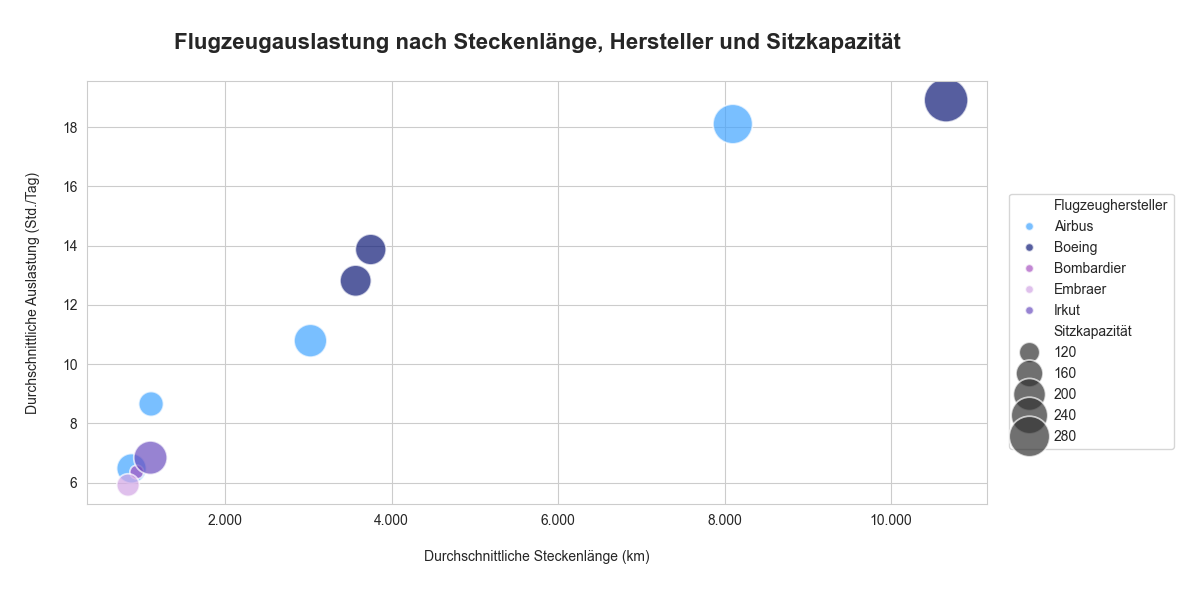

In [25]:
annotations_english = {
    "title": "Aircraft Utilization by Flight Distance, Manufacturer, and Seat Capacity",
    "x_label": "Average Flight Distance (km)",
    "y_label": "Average Utilization (hrs/day)",
    "size": "Seat Capacity",
    "hue": "Aircraft Manufacturer",
    "file": "(04)_aircraft_util"
}

annotations_german = {
    "title": "Flugzeugauslastung nach Steckenlänge, Hersteller und Sitzkapazität",
    "x_label": "Durchschnittliche Steckenlänge (km)",
    "y_label": "Durchschnittliche Auslastung (Std./Tag)",
    "size": "Sitzkapazität",
    "hue": "Flugzeughersteller",
    "file": "(04)_flugzeugauslastung"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

aircraft_util_local = aircraft_util.copy()
aircraft_util_local.rename(columns={"aircraft_manufacturer": annot["hue"], "seat_capacity": annot["size"]}, inplace=True)

# define palette for coloring by manufacturer
manufacturer_palette = [
    "#41A4FF",  # bright blue
    "#0E1A77",  # deep navy
    "#A855C1",  # medium purple
    "#D2A6E5",  # pale lilac
    "#6B4EBF"   # rich indigo, still distinct from navy
]

# plot
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(
    data=aircraft_util_local,
    x="avg_flight_distance_km", y="avg_util_hrs_daily",
    size=annot["size"], hue=annot["hue"],
    sizes=(100, 1000), alpha=0.7, palette=manufacturer_palette
)

# format colorbar, place legend
ax.xaxis.set_major_formatter(FuncFormatter(lambda x_, _: locale.format_string("%.0f", x_, grouping=True)))
ax.legend(bbox_to_anchor=(1.215, 0.75))

plt.title(f"\n{annot["title"]}\n", fontsize=16, fontweight="bold")
plt.xlabel(f"\n{annot["x_label"]}\n")
plt.ylabel(f"\n{annot["y_label"]}\n")
plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

#### Commercial Performance

In [26]:
aircraft_commercial = aircraft_mfr_model[[
    "aircraft_manufacturer", "aircraft_model",
    "avg_booked_rate_pct", "avg_occupancy_rate_pct", "avg_profit_margin_pct", "avg_profit", "total_profit"
]]

aircraft_commercial

,aircraft_manufacturer,aircraft_model,avg_booked_rate_pct,avg_occupancy_rate_pct,avg_profit_margin_pct,avg_profit,total_profit
0,Airbus,A220-300,"76,38","73,07","14,36",2.713,132.237.632
1,Airbus,A320neo,"75,45","72,04","13,57",2.364,129.652.225
2,Airbus,A321neo,"77,96","74,71","12,66",8.585,182.684.873
3,Airbus,A340-500,"85,97","83,34","16,39",39.876,422.003.815
4,Boeing,737 MAX 8,"80,54","77,49","15,07",10.454,204.879.446
5,Boeing,737 MAX 9,"79,51","76,37","13,56",8.754,186.759.771
6,Boeing,777-200LR,"85,79","83,13","15,84",59.698,651.481.339
7,Bombardier,CRJ900,"75,73","72,40","13,45",1.077,21.351.409
8,Embraer,E195-E2,"75,71","72,33","13,55",1.612,41.816.995
9,Irkut,MC-21-300,"76,60","73,27","14,09",3.444,151.910.246


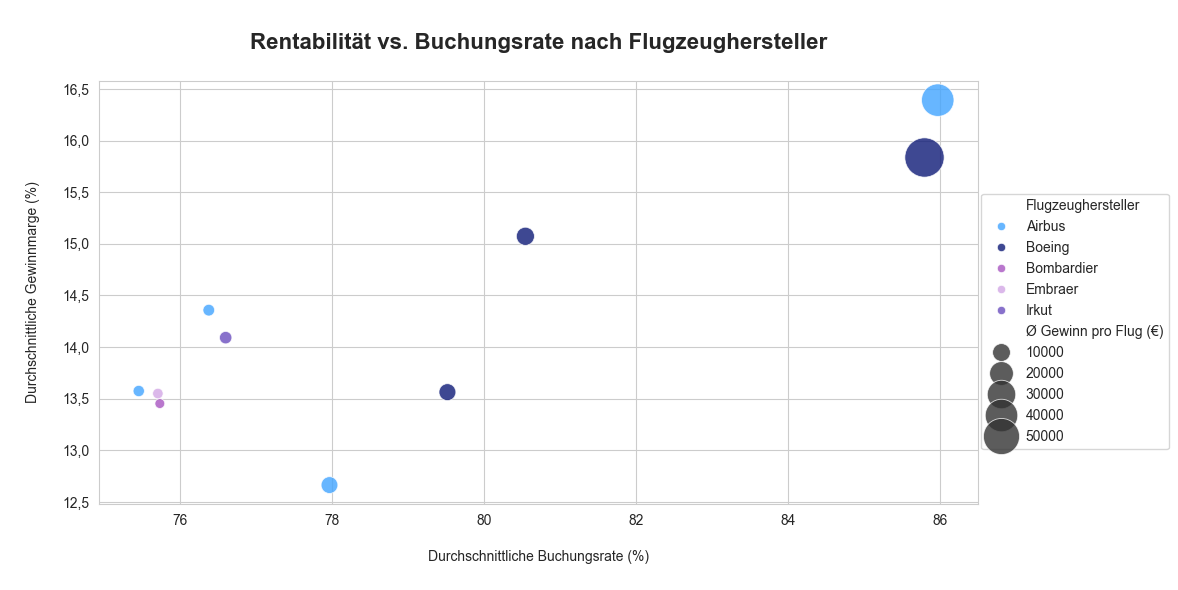

In [27]:
annotations_english = {
    "title": "Profitability vs Booked Rate by Aircraft Manufacturer",
    "x_label": "Average Booked Rate (%)",
    "y_label": "Average Profit Margin (%)",
    "size": "Avg Profit per Flight (€)",
    "hue": "Aircraft Manufacturer",
    "file": "(05)_aircraft_commercial"
}

annotations_german = {
    "title": "Rentabilität vs. Buchungsrate nach Flugzeughersteller",
    "x_label": "Durchschnittliche Buchungsrate (%)",
    "y_label": "Durchschnittliche Gewinnmarge (%)",
    "size": "Ø Gewinn pro Flug (€)",
    "hue": "Flugzeughersteller",
    "file": "(05)_flugzeug_kommerziell"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

aircraft_commercial_local = aircraft_commercial.copy()
aircraft_commercial_local.rename(columns={"aircraft_manufacturer": annot["hue"], "avg_profit": annot["size"]}, inplace=True)

# plot
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(
    data=aircraft_commercial_local,
    x="avg_booked_rate_pct", y="avg_profit_margin_pct",
    size=annot["size"], hue=annot["hue"],
    sizes=(50, 800), alpha=0.8, palette=manufacturer_palette
)

# format colorbar, place legend
ax.yaxis.set_major_formatter(FuncFormatter(lambda y_, _: locale.format_string("%.1f", y_, grouping=True)))
ax.legend(bbox_to_anchor=(1.225, 0.75))

plt.title(f"\n{annot["title"]}\n", fontsize=16, fontweight="bold")
plt.xlabel(f"\n{annot["x_label"]}\n")
plt.ylabel(f"\n{annot["y_label"]}\n")
plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

#### Profitability Stability

In [28]:
aircraft_profit_stability = aircraft_mfr_model[[
    "aircraft_manufacturer", "aircraft_model",
    "avg_flight_distance_km", "avg_profit", "std_profit"
]]

aircraft_profit_stability

,aircraft_manufacturer,aircraft_model,avg_flight_distance_km,avg_profit,std_profit
0,Airbus,A220-300,1.113,2.713,3.409
1,Airbus,A320neo,"877,48",2.364,3.301
2,Airbus,A321neo,3.027,8.585,10.467
3,Airbus,A340-500,8.099,39.876,27.577
4,Boeing,737 MAX 8,3.750,10.454,10.604
5,Boeing,737 MAX 9,3.569,8.754,9.388
6,Boeing,777-200LR,10.661,59.698,49.273
7,Bombardier,CRJ900,"940,68",1.077,1.486
8,Embraer,E195-E2,"836,18",1.612,2.218
9,Irkut,MC-21-300,1.105,3.444,4.800


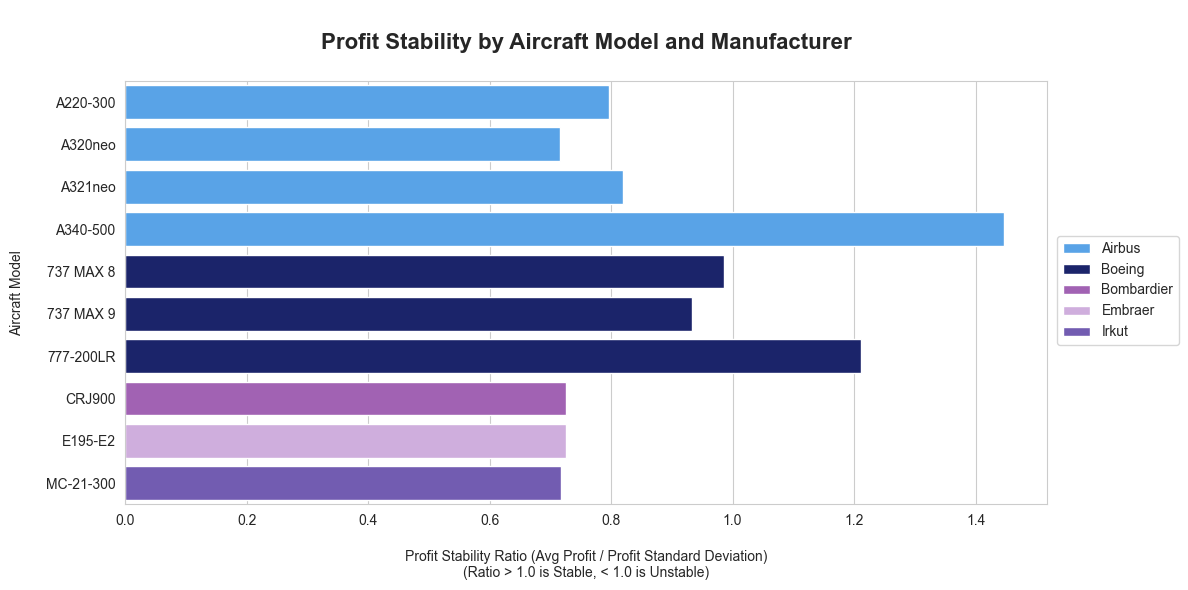

In [700]:
annotations_english = {
    "title": "Profit Stability by Aircraft Model and Manufacturer",
    "x_label": "Profit Stability Ratio (Avg Profit / Profit Standard Deviation)"
               "\n(Ratio > 1.0 is Stable, < 1.0 is Unstable)",
    "y_label": "Aircraft Model",
    "file": "(06)_aircraft_profit_stability"
}

annotations_german = {
    "title": "Gewinnstabilität nach Flugzeugmodell und Hersteller",
    "x_label": "Gewinnstabilitätsquote (Ø Gewinn / Gewinn-Standardabweichung)"
               "\n(> 1,0 = stabil, < 1,0 = instabil)",
    "y_label": "Flugzeugmodell",
    "file": "(06)_flugzeug_gewinnstabilität"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

# add the stability ratio column (avg profit / profit std)
aircraft_profit_stability_ = aircraft_profit_stability.copy()
aircraft_profit_stability_["stability_ratio"] = (
    aircraft_profit_stability_["avg_profit"] / aircraft_profit_stability_["std_profit"]
)

# plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=aircraft_profit_stability_, x="stability_ratio", y="aircraft_model",
                 hue="aircraft_manufacturer", palette=manufacturer_palette)

# format colorbar, place legend
ax.xaxis.set_major_formatter(FuncFormatter(lambda x_, _: locale.format_string("%.1f", x_, grouping=True)))
ax.legend(bbox_to_anchor=(1.15, 0.65))

plt.title(f"\n{annot["title"]}\n", fontsize=16, fontweight="bold")
plt.xlabel(f"\n{annot["x_label"]}")
plt.ylabel(f"{annot["y_label"]}\n")
plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

#### Operational Reliability

In [30]:
aircraft_reliability = aircraft_mfr_model[[
    "aircraft_manufacturer", "aircraft_model",
    "avg_delay_mins_dep", "avg_delay_mins_arr", "tech_failure_cxl_rate_pct", "tech_issue_delay_rate_pct"
]]

aircraft_reliability

,aircraft_manufacturer,aircraft_model,avg_delay_mins_dep,avg_delay_mins_arr,tech_failure_cxl_rate_pct,tech_issue_delay_rate_pct
0,Airbus,A220-300,"35,47","37,11","1,00","7,67"
1,Airbus,A320neo,"34,83","36,84","0,92","7,85"
2,Airbus,A321neo,"46,98","48,19","0,95","7,50"
3,Airbus,A340-500,"52,27","52,49","0,94","7,08"
4,Boeing,737 MAX 8,"53,25","53,31","0,98","7,40"
5,Boeing,737 MAX 9,"52,24","53,08","0,95","7,14"
6,Boeing,777-200LR,"51,67","50,62","1,04","7,15"
7,Bombardier,CRJ900,"34,64","36,85","0,88","7,17"
8,Embraer,E195-E2,"34,69","36,50","0,94","7,86"
9,Irkut,MC-21-300,"36,50","38,00","0,91","7,60"


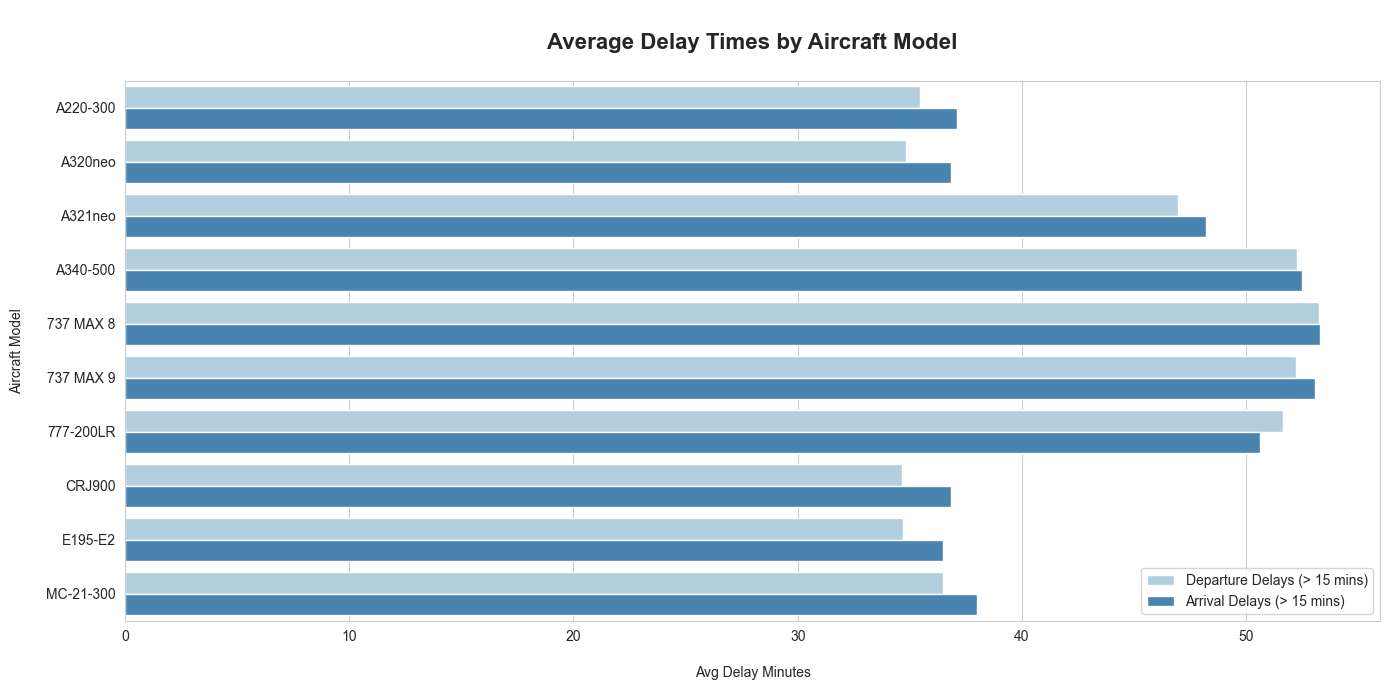

In [701]:
annotations_english = {
    "title": "Average Delay Times by Aircraft Model",
    "x_label": "Avg Delay Minutes",
    "y_label": "Aircraft Model",
    "legend_a": "Departure Delays (> 15 mins)",
    "legend_b": "Arrival Delays (> 15 mins)",
    "file": "(07)_aircraft_reliability"
}

annotations_german = {
    "title": "Durchschnittliche Verspätungszeiten nach Flugzeugmodell",
    "x_label": "Durchschnittliche Verspätung (Minuten)",
    "y_label": "Flugzeugmodell",
    "legend_a": "Abflugverspätungen (> 15 Min.)",
    "legend_b": "Ankunftsverspätungen (> 15 Min.)",
    "file": "(07)_flugzeug_verlässlichkeit"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

aircraft_reliability_local = aircraft_reliability.copy()
aircraft_reliability_local.rename(columns={"avg_delay_mins_dep": annot["legend_a"], "avg_delay_mins_arr": annot["legend_b"]}, inplace=True)

# use melt() to convert from wide to long format
reliability = aircraft_reliability_local.melt(
    id_vars=["aircraft_model", "aircraft_manufacturer"],
    value_vars=[annot["legend_a"], annot["legend_b"]],
    var_name="issue_type", value_name="rate_pct"
)

# plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=reliability, x="rate_pct", y="aircraft_model", hue="issue_type", palette="Blues")
ax.legend(bbox_to_anchor=(1.0, 0.11))

plt.title(f"\n{annot["title"]}\n", fontsize=16, fontweight="bold")
plt.xlabel(f"\n{annot["x_label"]}")
plt.ylabel(f"{annot["y_label"]}\n")
plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

## Customer Behavior

In [12]:
# add frequent flyer status names to df_bookings, drop status code
customer_stats = df_bookings.merge(df_freq_flyer_discounts[["frequent_flyer_status_code", "frequent_flyer_status"]], on="frequent_flyer_status_code")
customer_stats = customer_stats.drop(columns="frequent_flyer_status_code")

# create boolean passenger class columns
customer_stats["economy"] = customer_stats["class_name"] == "Economy"
customer_stats["business"] = customer_stats["class_name"] == "Business"
customer_stats["first_cl"] = customer_stats["class_name"] == "First"

# create boolean frequent flyer status columns
customer_stats["no_status"] = customer_stats["frequent_flyer_status"] == "No Status"
customer_stats["basic_status"] = customer_stats["frequent_flyer_status"] == "Basic"
customer_stats["silver_status"] = customer_stats["frequent_flyer_status"] == "Silver"
customer_stats["gold_status"] = customer_stats["frequent_flyer_status"] == "Gold"
customer_stats["platinum_status"] = customer_stats["frequent_flyer_status"] == "Platinum"

# calculate booking lead times (days between booking date and flight date)
customer_stats["booking_lead_time_days"] = (customer_stats["flight_date"] - customer_stats["booking_time"]).dt.days

# create boolean lead time columns
customer_stats["lead_time_within_4_weeks"] = customer_stats["booking_lead_time_days"] <= 28
customer_stats["lead_time_within_6_weeks"] = customer_stats["booking_lead_time_days"].between(29, 42)
customer_stats["lead_time_within_8_weeks"] = customer_stats["booking_lead_time_days"].between(43, 56)
customer_stats["lead_time_within_10_weeks"] = customer_stats["booking_lead_time_days"].between(57, 70)
customer_stats["lead_time_within_12_weeks"] = customer_stats["booking_lead_time_days"].between(71, 84)
customer_stats["lead_time_over_12_weeks"] = customer_stats["booking_lead_time_days"] > 84

# extract hour from booking time
customer_stats["booking_hour"] = customer_stats["booking_time"].dt.hour

# create boolean booking hour columns
customer_stats["booking_hour_btw_06_and_12"] = customer_stats["booking_hour"].between(6, 11)
customer_stats["booking_hour_btw_12_and_17"] = customer_stats["booking_hour"].between(12, 16)
customer_stats["booking_hour_btw_17_and_22"] = customer_stats["booking_hour"].between(17, 21)
customer_stats["booking_hour_btw_22_and_06"] = (customer_stats["booking_hour"] >= 22) | (customer_stats["booking_hour"] < 6)

# merge customer attribute columns on main df, clean values
customer_stats = customer_stats.merge(df_customers[["customer_id", "date_of_birth", "nationality", "gender"]], on="customer_id")
customer_stats["gender"] = customer_stats["gender"].replace({"male": "Male", "female": "Female"})

# classify customers into age groups:
    # pick the latest flight per customer and calculate a canonical customer age based on the time of the latest flight
    # (this will slightly distort age stats for earlier flights but prevent unique customers from being counted multiple times)
latest_flight_per_customer = (
    customer_stats[["customer_id", "flight_date", "date_of_birth"]].sort_values("flight_date")
    .groupby("customer_id", as_index=False).tail(1)  # keep only the most recent flight
)
latest_flight_per_customer["age"] = (
    (latest_flight_per_customer["flight_date"] - latest_flight_per_customer["date_of_birth"]).dt.days / 365.25
)

# add canonical customer ages to main df
customer_stats = customer_stats.merge(latest_flight_per_customer[["customer_id", "age"]], on="customer_id")

age_ranges = [
    customer_stats["age"] <= 24, customer_stats["age"].between(25, 34),
    customer_stats["age"].between(35, 44), customer_stats["age"].between(45, 60),
    customer_stats["age"] > 60
]

age_groups = ["(1) Age <= 24", "(2) Age 25-34", "(3) Age 35-44", "(4) Age 45-60", "(5) Age > 60"]

customer_stats["age_group"] = np.select(age_ranges, age_groups, default="Unknown")

#customer_stats

In [13]:
# group by gender and age_group, aggregate relevant columns
gender_age_stats = customer_stats.groupby(["gender", "age_group"]).agg(
    total_bookings=("booking_id", "count"),
    customer_share_pct=("customer_id", "nunique"),
    checked_in_rate_pct=("checked_in", "sum"),
    economy_bookings_pct=("economy", "sum"),
    business_bookings_pct=("business", "sum"),
    first_cl_bookings_pct=("first_cl", "sum"),
    no_status_flyers_pct=("no_status", "sum"),
    basic_status_flyers_pct=("basic_status", "sum"),
    silver_status_flyers_pct=("silver_status", "sum"),
    gold_status_flyers_pct=("gold_status", "sum"),
    platinum_status_flyers_pct=("platinum_status", "sum"),
    lead_times_within_4_weeks_pct=("lead_time_within_4_weeks", "sum"),
    lead_times_within_6_weeks_pct=("lead_time_within_6_weeks", "sum"),
    lead_times_within_8_weeks_pct=("lead_time_within_8_weeks", "sum"),
    lead_times_within_10_weeks_pct=("lead_time_within_10_weeks", "sum"),
    lead_times_within_12_weeks_pct=("lead_time_within_12_weeks", "sum"),
    lead_times_over_12_weeks_pct=("lead_time_over_12_weeks", "sum")
    ).reset_index()

# convert column values to percentages

pos_tb = gender_age_stats.columns.get_loc("total_bookings") + 1
gender_age_stats.insert(3, "bookings_share_pct", gender_age_stats["total_bookings"] / gender_age_stats["total_bookings"].sum()  * 100)

gender_age_stats["customer_share_pct"] = (
        gender_age_stats["customer_share_pct"] / gender_age_stats["customer_share_pct"].sum() * 100
)

for col in gender_age_stats.drop(columns=["gender", "age_group", "total_bookings", "bookings_share_pct", "customer_share_pct"]).columns:
    gender_age_stats[col] = gender_age_stats[col] / gender_age_stats["total_bookings"] * 100

# add missed_checked_in_rate_pct
pos_ci = gender_age_stats.columns.get_loc("checked_in_rate_pct") + 1
gender_age_stats.insert(pos_ci, "missed_checked_in_rate_pct", 100 - gender_age_stats["checked_in_rate_pct"])

gender_age_stats

,gender,age_group,total_bookings,bookings_share_pct,customer_share_pct,checked_in_rate_pct,missed_checked_in_rate_pct,economy_bookings_pct,business_bookings_pct,first_cl_bookings_pct,...,basic_status_flyers_pct,silver_status_flyers_pct,gold_status_flyers_pct,platinum_status_flyers_pct,lead_times_within_4_weeks_pct,lead_times_within_6_weeks_pct,lead_times_within_8_weeks_pct,lead_times_within_10_weeks_pct,lead_times_within_12_weeks_pct,lead_times_over_12_weeks_pct
0,Female,(1) Age <= 24,3227793,"7,94","10,84","90,93","9,07","89,37","10,06","0,57",...,"3,41","6,72","1,37","0,05","6,81","36,86","45,24","10,64","0,46","0,00"
1,Female,(2) Age 25-34,6371097,"15,68","17,14","92,66","7,34","88,19","11,16","0,65",...,"38,87","6,04","1,23","0,04","3,24","24,45","50,53","20,25","1,51","0,01"
2,Female,(3) Age 35-44,4341878,"10,69","9,73","93,24","6,76","86,45","12,81","0,74",...,"57,22","9,10","1,82","0,06","1,70","13,45","47,87","32,67","4,21","0,10"
3,Female,(4) Age 45-60,2086489,"5,13","3,63","93,35","6,65","80,15","18,85","1,00",...,"52,69","31,64","6,38","0,18","1,15","5,42","35,51","45,58","11,76","0,58"
4,Female,(5) Age > 60,1301125,"3,20","2,25","92,28","7,72","73,65","25,12","1,23",...,"6,50","62,20","12,97","0,38","1,01","0,58","11,53","44,67","36,05","6,17"
5,Female,Unknown,1918196,"4,72","4,83","92,65","7,35","87,31","12,00","0,69",...,"45,17","8,09","1,69","0,04","3,02","21,17","47,85","24,81","3,06","0,11"
6,Male,(1) Age <= 24,3216627,"7,92","10,64","89,96","10,04","88,90","10,50","0,60",...,"4,16","8,22","1,67","0,05","15,09","47,86","32,76","4,26","0,03","0,00"
7,Male,(2) Age 25-34,6917586,"17,02","17,85","91,71","8,29","87,78","11,54","0,68",...,"43,78","6,80","1,38","0,04","7,52","38,34","44,04","9,71","0,39","0,00"
8,Male,(3) Age 35-44,4968962,"12,23","10,74","92,32","7,68","86,12","13,13","0,75",...,"60,94","9,77","1,94","0,06","3,45","25,53","50,43","19,22","1,37","0,00"
9,Male,(4) Age 45-60,2553324,"6,28","4,44","92,41","7,59","80,07","18,93","1,00",...,"52,47","31,80","6,46","0,20","1,67","12,77","46,65","33,90","4,92","0,09"


In [19]:
# get the most frequent booking hour per nationality
most_freq_booking_hours = (
    customer_stats.groupby("nationality")["booking_hour"]
    .agg(lambda x: x.mode()[0]).rename("most_freq_bkg_hour")
)

# group by nationality, aggregate booking hour columns
nationality_stats = customer_stats.groupby("nationality").agg(
    total_bookings=("booking_id", "count"),
    pct_bookings_btw_06_and_12=("booking_hour_btw_06_and_12", "sum"),
    pct_bookings_btw_12_and_17=("booking_hour_btw_12_and_17", "sum"),
    pct_bookings_btw_17_and_22=("booking_hour_btw_17_and_22", "sum"),
    pct_bookings_btw_22_and_06=("booking_hour_btw_22_and_06", "sum")
    ).reset_index()

# convert column values to percentages

pos_tb = nationality_stats.columns.get_loc("total_bookings") + 1
nationality_stats.insert(pos_tb, "bookings_share_pct", nationality_stats["total_bookings"] / nationality_stats["total_bookings"].sum() * 100)

for col in nationality_stats[["pct_bookings_btw_06_and_12", "pct_bookings_btw_12_and_17",
                              "pct_bookings_btw_17_and_22", "pct_bookings_btw_22_and_06"]].columns:
    nationality_stats[col] = nationality_stats[col] / nationality_stats["total_bookings"] * 100

# add in the most frequent booking hour column
nationality_stats = nationality_stats.merge(most_freq_booking_hours, on="nationality")

nationality_stats

,nationality,total_bookings,bookings_share_pct,pct_bookings_btw_06_and_12,pct_bookings_btw_12_and_17,pct_bookings_btw_17_and_22,pct_bookings_btw_22_and_06,most_freq_bkg_hour
0,Australia,238976,"0,59","23,44","32,97","38,28","5,31",20
1,Austria,2882513,"7,09","42,01","31,81","22,53","3,65",8
2,Brazil,478289,"1,18","18,59","27,88","48,26","5,27",20
3,Canada,479876,"1,18","32,20","36,65","27,48","3,67",16
4,Denmark,963252,"2,37","45,82","35,69","16,52","1,98",9
5,Finland,961135,"2,37","50,70","30,76","16,54","1,99",7
6,France,5773285,"14,21","32,18","36,71","27,49","3,62",13
7,Germany,12023682,"29,59","45,81","30,71","21,50","1,99",11
8,Italy,1202851,"2,96","22,21","31,80","42,35","3,65",20
9,Netherlands,962955,"2,37","42,03","31,77","22,55","3,65",9


In [15]:
# German translations gender and age
gender_age_stats["gender_ger"] = gender_age_stats["gender"].replace("Female", "Weiblich").replace("Male", "Männlich")
gender_age_stats["age_group_ger"] = (
    gender_age_stats["age_group"]
    .replace("(1) Age <= 24", "(1) Alter <= 24").replace("(2) Age 25-34", "(2) Alter 25-34")
    .replace("(3) Age 35-44", "(3) Alter 35-44").replace("(4) Age 45-60", "(4) Alter 45-60")
    .replace("(5) Age > 60", "(5) Alter > 60").replace("Unknown", "Unbekannt")
)

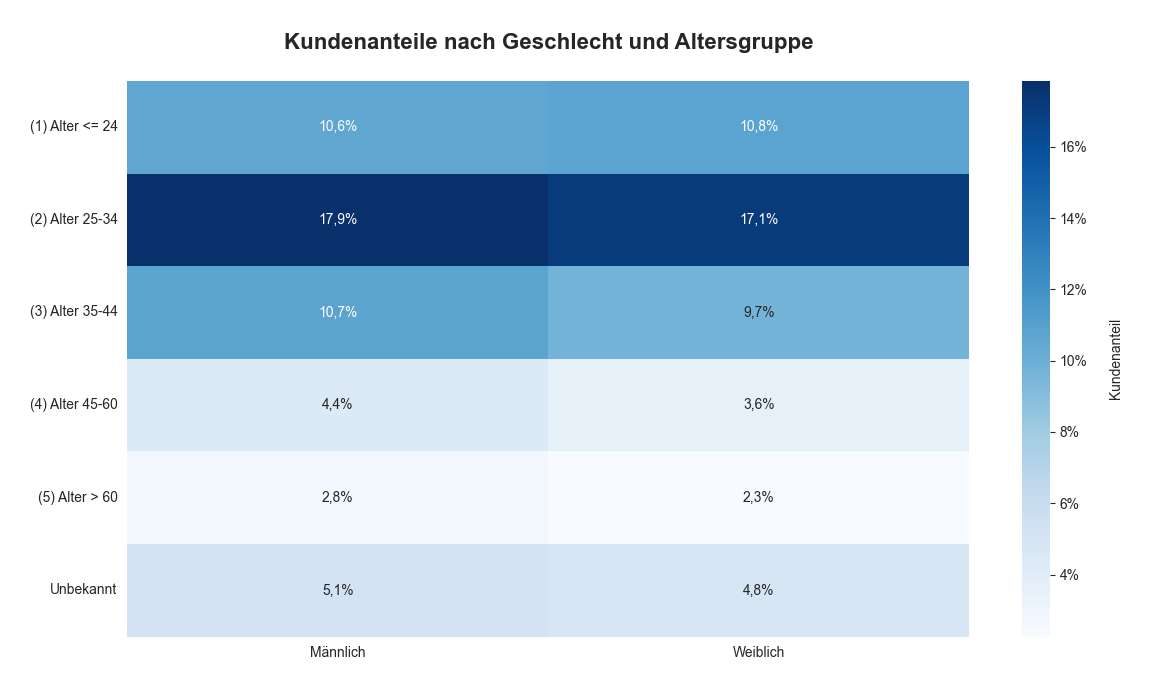

In [720]:
annotations_english = {
    "title": "Customer Shares (%) by Gender and Age Group",
    "legend": "Customer Share",
    "idx": "age_group",
    "col": "gender",
    "file": "(08)_customer_age_gender"
}

annotations_german = {
    "title": "Kundenanteile nach Geschlecht und Altersgruppe",
    "legend": "Kundenanteil",
    "idx": "age_group_ger",
    "col": "gender_ger",
    "file": "(08)_kunden_alter_geschlecht"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

# create a pivot table for heatmap
gender_age_pivot = gender_age_stats.pivot(index=annot["idx"], columns=annot["col"], values="customer_share_pct")

# create formatted cell labels for annotations
cell_labels = gender_age_pivot.copy().map(
    lambda v_: locale.format_string("%.1f", v_, grouping=True) + "%" if pd.notna(v_) else ""
)

# plot
plt.figure(figsize=(12, 7))
ax = sns.heatmap(gender_age_pivot, annot=cell_labels, fmt="", cmap="Blues", cbar_kws={"label": f"\n{annot["legend"]}\n"})

# format colorbar
ax.collections[0].colorbar.ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: locale.format_string("%.0f", x, grouping=True)+ "%")
)

plt.title(f"\n{annot["title"]}\n", fontsize=16, weight="bold")
plt.xlabel(" ")
plt.ylabel(" ")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

In [478]:
# German translations nationality
nationalities_eng_ger = {
    "Australia": "Australien", "Austria": "Österreich", "Brazil": "Brasilien", "Canada": "Kanada",
    "Denmark": "Dänemark", "Finland": "Finnland", "France": "Frankreich", "Germany": "Deutschland",
    "Italy": "Italien", "Netherlands": "Niederlande", "Norway": "Norwegen", "Poland": "Polen",
    "Portugal": "Portugal", "Spain": "Spanien", "Sweden": "Schweden", "Switzerland": "Schweiz",
    "United Kingdom": "Vereinigtes Königreich", "United States":"Vereinigte Staaten"
}

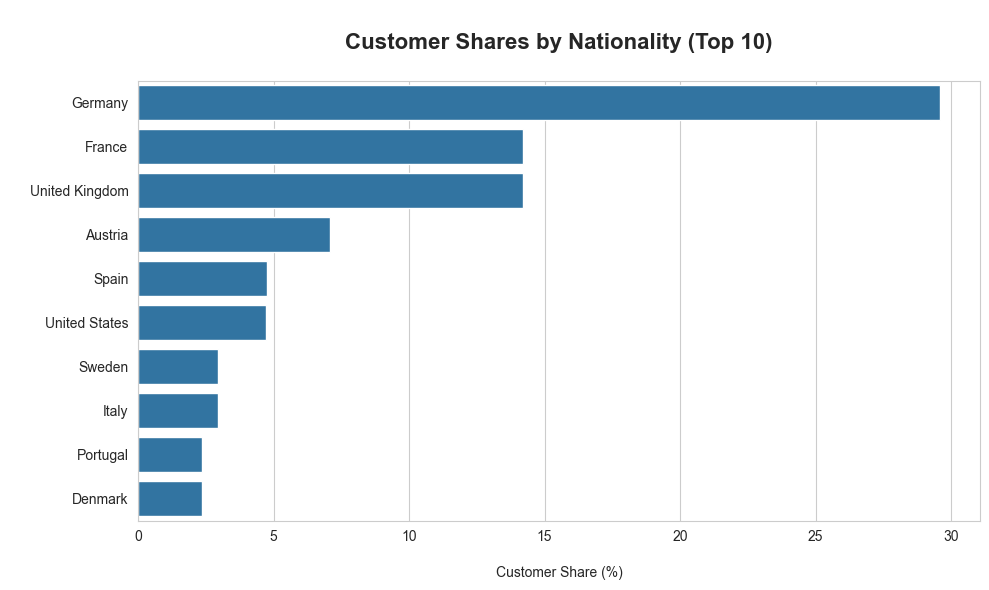

In [703]:
annotations_english = {
    "title": "Customer Shares by Nationality (Top 10)",
    "x_label": "Customer Share (%)",
    "nat": "nationality",
    "file": "(09)_customer_nationality"
}

annotations_german = {
    "title": "Kundenanteile nach Nationalität (Top 10)",
    "x_label": "Kundenanteil (%)",
    "nat": "nationality_ger",
    "file": "(09)_kunden_nationalität"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

# extract the top 10 nationalities (by total bookings), localize
top_n = nationality_stats.nlargest(10, "total_bookings")
top_n["nationality_ger"] = top_n["nationality"].map(nationalities_eng_ger)

# plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_n,
    x="bookings_share_pct",
    y=annot["nat"],
    orient="h",
)

plt.title(f"\n{annot["title"]}\n", fontsize=16, weight="bold")
plt.xlabel(f"\n{annot["x_label"]}")
plt.ylabel(" ")
plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

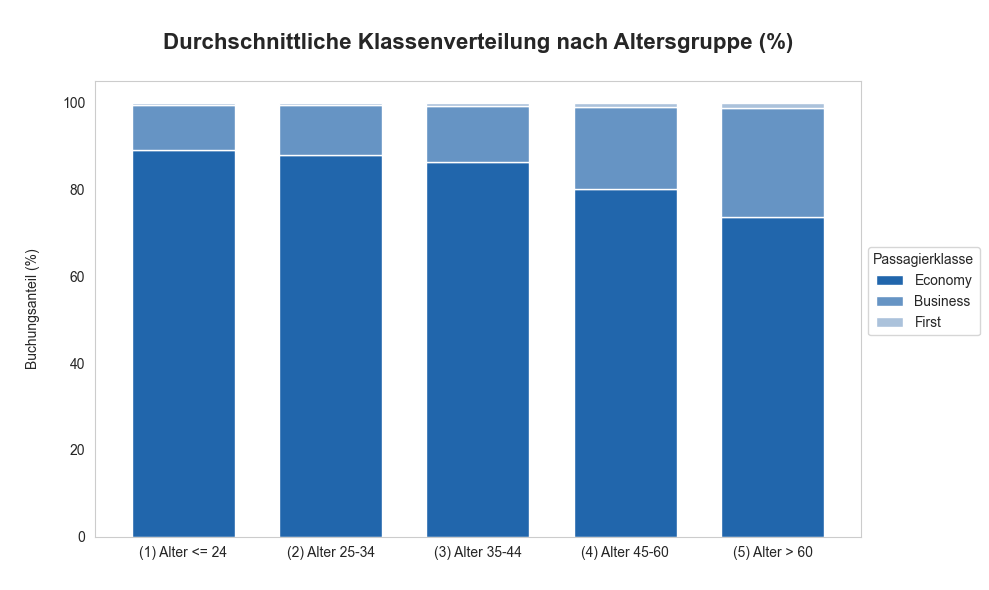

In [721]:
annotations_english = {
    "title": "Average Booking Class Mix by Age Group (%)",
    "y_label": "Share of Bookings (%)",
    "legend": "Passenger Class",
    "idx": "age_group",
    "file": "(10)_bookings_class"
}

annotations_german = {
    "title": "Durchschnittliche Klassenverteilung nach Altersgruppe (%)",
    "y_label": "Buchungsanteil (%)",
    "legend": "Passagierklasse",
    "idx": "age_group_ger",
    "file": "(10)_buchungen_klasse"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

class_cols = ["economy_bookings_pct", "business_bookings_pct", "first_cl_bookings_pct"]

# get age group averages for class booking shares, ensure correct order, localize
subset_eng = (
    gender_age_stats.query("age_group != 'Unknown'").groupby("age_group")[class_cols].mean()
    .reindex(sorted(gender_age_stats.query("age_group != 'Unknown'")["age_group"].unique()))
)
subset_ger = (
    gender_age_stats.query("age_group_ger != 'Unbekannt'").groupby("age_group_ger")[class_cols].mean()
    .reindex(sorted(gender_age_stats.query("age_group_ger != 'Unbekannt'")["age_group_ger"].unique()))
)

subset = [subset_ger if language_setting == "de" else subset_eng][0]

# plot
subset.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    width=0.7,
    color=sns.light_palette("#2166ac", n_colors=4, reverse=True)
)

plt.title(f"\n{annot["title"]}\n", fontsize=16, weight="bold")
plt.xlabel(" ")
plt.xticks(rotation=0)
plt.ylabel(f"\n{annot["y_label"]}\n")
plt.legend(["Economy", "Business", "First"], title=annot["legend"], bbox_to_anchor=(1.0, 0.65))
plt.grid()
plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

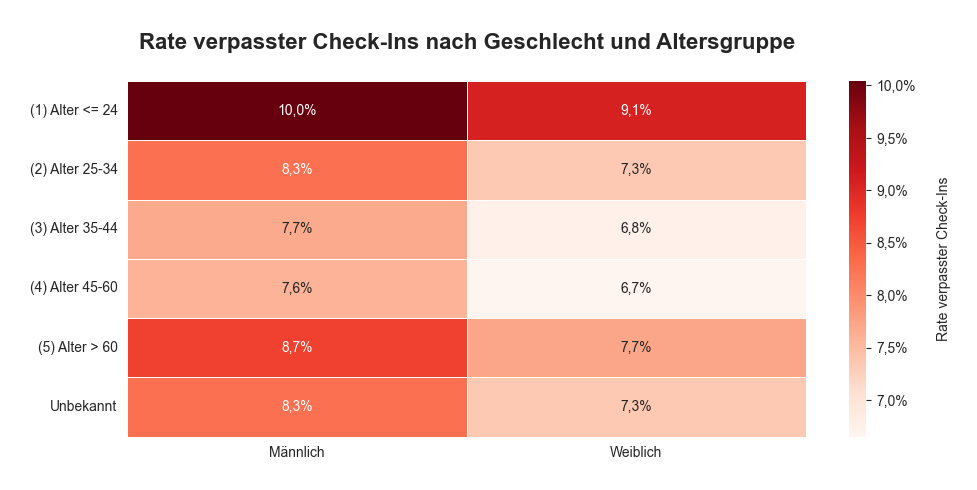

In [727]:
annotations_english = {
    "title": "Missed Check-In Rate by Gender and Age Group",
    "legend": "Missed Check-In Rate",
    "idx": "age_group",
    "col": "gender",
    "file": "(11)_missed_check_ins"
}

annotations_german = {
    "title": "Rate verpasster Check-Ins nach Geschlecht und Altersgruppe",
    "legend": "Rate verpasster Check-Ins",
    "idx": "age_group_ger",
    "col": "gender_ger",
    "file": "(11)_verpasste_check_ins"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

# create pivot table
check_in = gender_age_stats.pivot(
    index=annot["idx"], columns=annot["col"], values="missed_checked_in_rate_pct"
).sort_index()

# create formatted cell labels for annotations
cell_labels = check_in.map(
    lambda v_: locale.format_string("%.1f", v_, grouping=True) + "%" if pd.notna(v_) else "")

# plot
plt.figure(figsize=(10, 5))
ax = sns.heatmap(
    check_in,
    annot=cell_labels, fmt="", cmap="Reds", linewidths=0.5, cbar_kws={"label": f"\n{annot["legend"]}\n"}
)

# format colorbar
ax.collections[0].colorbar.ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: locale.format_string("%.1f", x, grouping=True) + "%")
)

plt.title(f"\n{annot["title"]}\n", fontsize=16, weight="bold")
plt.xlabel(" ")
plt.ylabel(" ")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

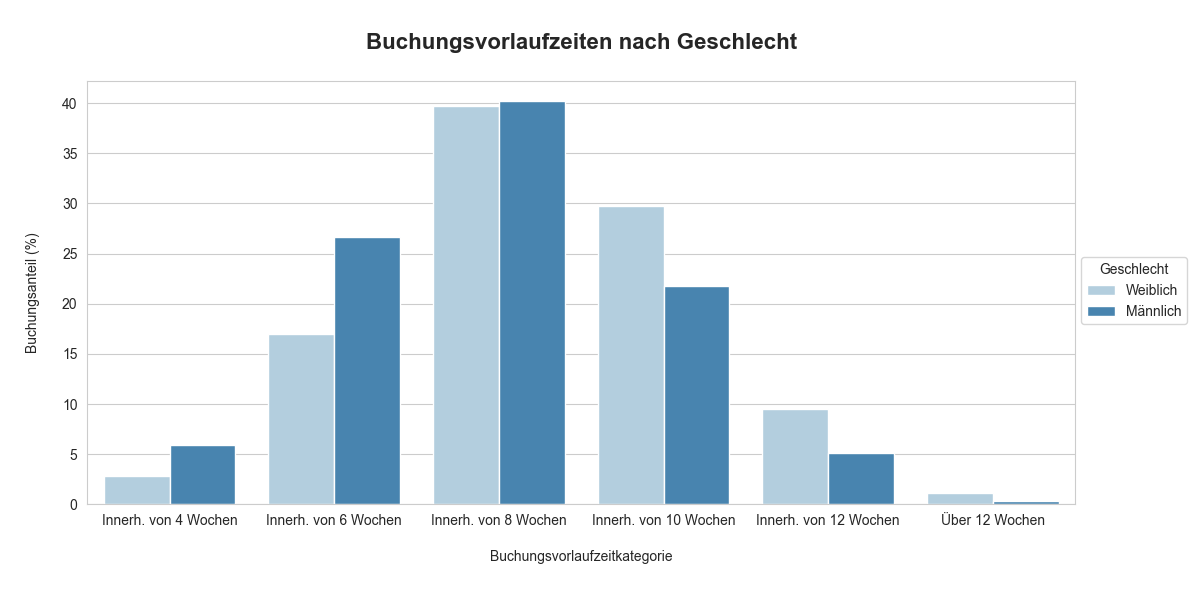

In [20]:
annotations_english = {
    "title": "Booking Lead Time Distribution by Gender",
    "x_label": "Booking Lead Time Category",
    "y_label": "Share of Bookings (%)",
    "legend": "Gender",
    "hue": "gender",
    "file": "(12)_lead_times_gender"
}

annotations_german = {
    "title": "Buchungsvorlaufzeiten nach Geschlecht",
    "x_label": "Buchungsvorlaufzeitkategorie",
    "y_label": "Buchungsanteil (%)",
    "legend": "Geschlecht",
    "hue": "gender_ger",
    "file": "(12)_vorlaufzeiten_geschlecht"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

lead_time_cols = [
    "lead_times_within_4_weeks_pct",
    "lead_times_within_6_weeks_pct",
    "lead_times_within_8_weeks_pct",
    "lead_times_within_10_weeks_pct",
    "lead_times_within_12_weeks_pct",
    "lead_times_over_12_weeks_pct"
]

# Melt into long form for plotting
lead_time_melted_eng = gender_age_stats.melt(
    id_vars=annot["hue"],
    value_vars=lead_time_cols,
    var_name="lead_time_range",
    value_name="pct_bookings"
)

lead_times_eng_ger = {
    "Within 4 Weeks": "Innerh. von 4 Wochen",
    "Within 6 Weeks": "Innerh. von 6 Wochen",
    "Within 8 Weeks": "Innerh. von 8 Wochen",
    "Within 10 Weeks": "Innerh. von 10 Wochen",
    "Within 12 Weeks": "Innerh. von 12 Wochen",
    "Over 12 Weeks": "Über 12 Wochen"
}

# Clean up labels
lead_time_melted_eng["lead_time_range"] = lead_time_melted_eng["lead_time_range"].str.replace("lead_times_", "")
lead_time_melted_eng["lead_time_range"] = (
    lead_time_melted_eng["lead_time_range"].str.replace("_pct", "").str.replace("_", " ").str.title()
)

lead_time_melted_ger = lead_time_melted_eng.copy()
lead_time_melted_ger["lead_time_range"] = lead_time_melted_ger["lead_time_range"].map(lead_times_eng_ger)

lead_time_melted = [lead_time_melted_ger if language_setting == "de" else lead_time_melted_eng][0]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=lead_time_melted,
    x="lead_time_range",
    y="pct_bookings",
    hue=annot["hue"],
    palette="Blues",
    errorbar=None
)

plt.title(f"\n{annot["title"]}\n", fontsize=16, fontweight="bold")
plt.xlabel(f"\n{annot["x_label"]}\n")
plt.ylabel(f"\n{annot["y_label"]}\n")
plt.legend(title=annot["legend"], bbox_to_anchor=(1.12, 0.6))
plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

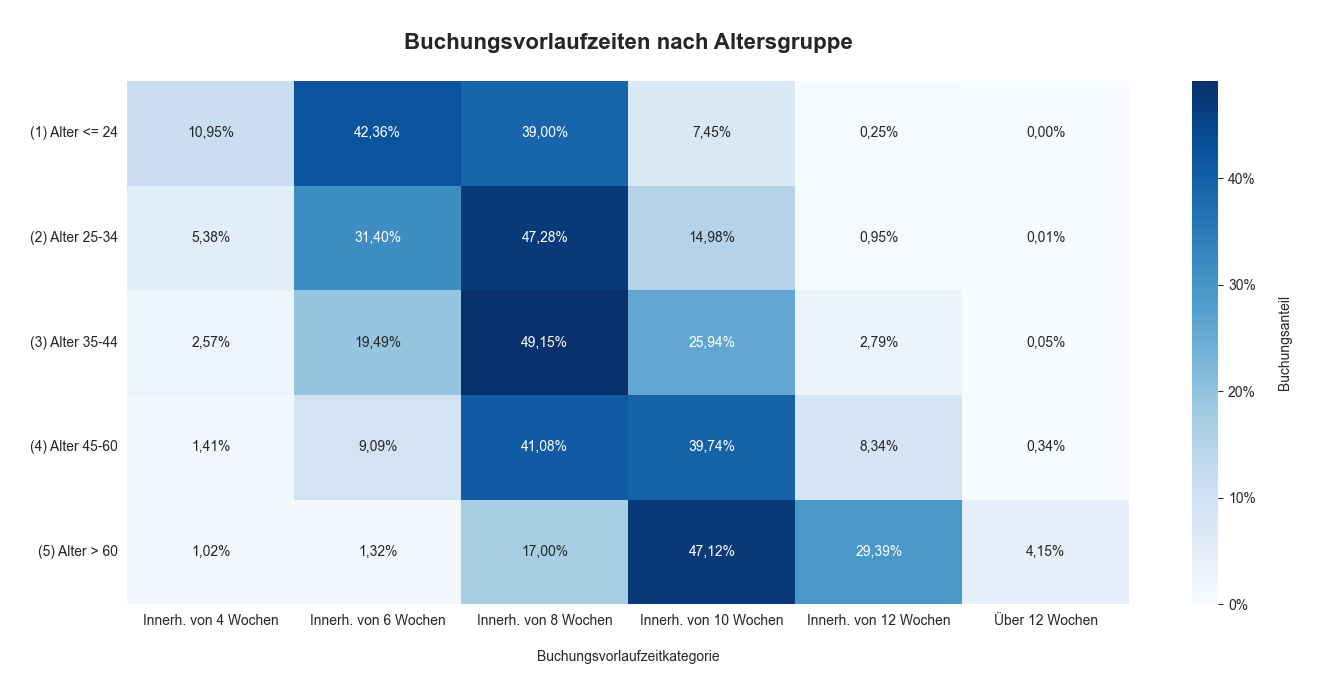

In [21]:
annotations_english = {
    "title": "Booking Lead Time Distribution by Age Group",
    "x_label": "Booking Lead Time Category",
    "legend": "Share of Bookings",
    "y": "age_group",
    "file": "(13)_lead_times_age"
}

annotations_german = {
    "title": "Buchungsvorlaufzeiten nach Altersgruppe",
    "x_label": "Buchungsvorlaufzeitkategorie",
    "legend": "Buchungsanteil",
    "y": "age_group_ger",
    "file": "(13)_vorlaufzeiten_alter"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

lead_time_heat_eng = (
    gender_age_stats.query("age_group != 'Unknown'").groupby(annot["y"])[lead_time_cols].mean().sort_index()
)

# Clean labels
lead_time_heat_eng.columns = [
    col.replace("lead_times_", "").replace("_pct", "").replace("_", " ").title()
    for col in lead_time_heat_eng.columns
]

lead_time_heat_ger = lead_time_heat_eng.copy()
lead_time_heat_ger.columns = [
    "Innerh. von 4 Wochen", "Innerh. von 6 Wochen", "Innerh. von 8 Wochen",
    "Innerh. von 10 Wochen", "Innerh. von 12 Wochen", "Über 12 Wochen"
]

lead_time_heat = [lead_time_heat_ger if language_setting == "de" else lead_time_heat_eng][0]

# Create formatted cell labels for annotations
cell_labels = lead_time_heat.copy().map(
    lambda v_: locale.format_string("%.2f", v_, grouping=True) + "%" if pd.notna(v_) else ""
)

plt.figure(figsize=(14, 7))
ax = sns.heatmap(
    lead_time_heat, annot=cell_labels, fmt="", cmap="Blues",
    cbar_kws={"label": f"\n{annot["legend"]}\n"}
)

ax.collections[0].colorbar.ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: locale.format_string("%.0f", x, grouping=True)+ "%")
)

plt.title(f"\n{annot["title"]}\n", fontsize=16, weight="bold")
plt.xlabel(f"\n{annot["x_label"]}\n")
plt.ylabel(" ")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

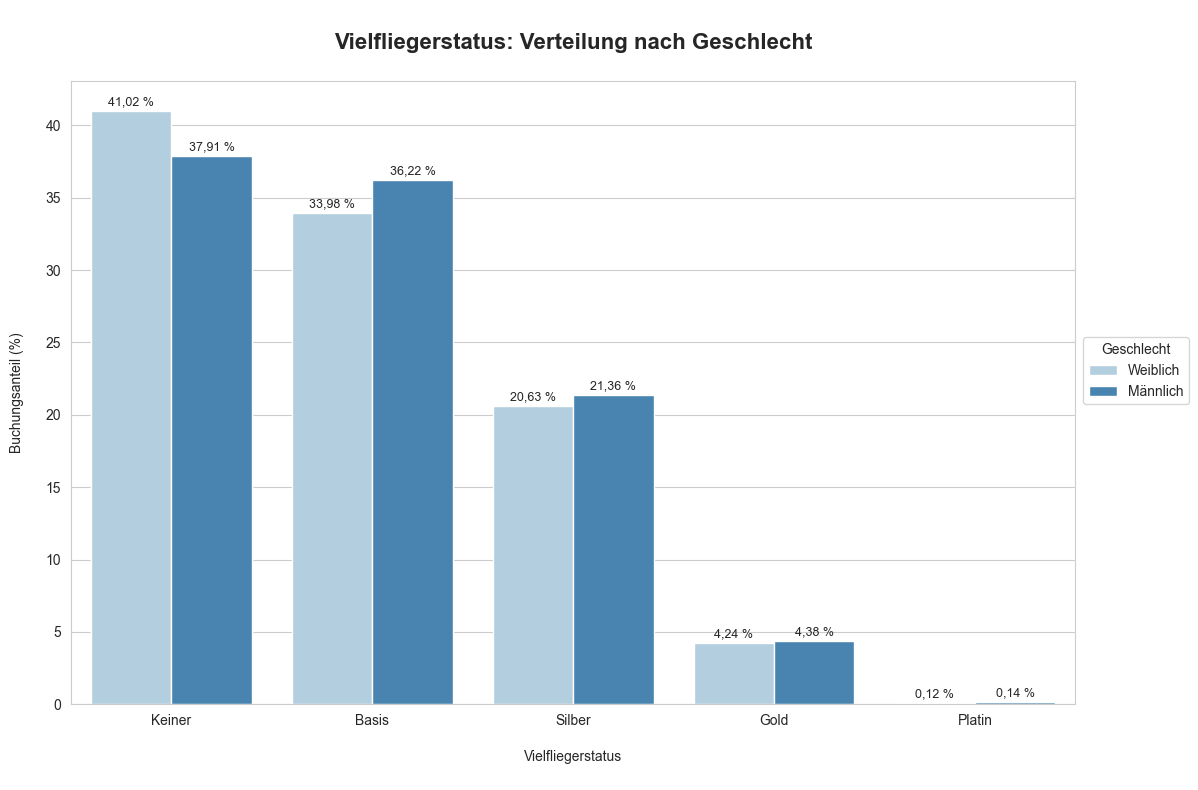

In [16]:
annotations_english = {
    "title": "Frequent Flyer Status Distribution by Gender",
    "x_label": "Frequent Flyer Status",
    "y_label": "Share of Bookings (%)",
    "legend": "Gender",
    "id_vars": "gender",
    "file": "(14)_flyer_status_gender"
}

annotations_german = {
    "title": "Vielfliegerstatus: Verteilung nach Geschlecht",
    "x_label": "Vielfliegerstatus",
    "y_label": "Buchungsanteil (%)",
    "legend": "Geschlecht",
    "id_vars": "gender_ger",
    "file": "(14)_fliegerstatus_geschlecht"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

# Define relevant columns
freq_tier_cols = [
    "no_status_flyers_pct",
    "basic_status_flyers_pct",
    "silver_status_flyers_pct",
    "gold_status_flyers_pct",
    "platinum_status_flyers_pct"
]

# Melt into long form for plotting
freq_tier_melted_eng = gender_age_stats.melt(
    id_vars=annot["id_vars"],
    value_vars=freq_tier_cols,
    var_name="frequent_flyer_tier",
    value_name="pct_bookings"
)

# Clean up labels
freq_tier_melted_eng["frequent_flyer_tier"] = (
    freq_tier_melted_eng["frequent_flyer_tier"].str.replace("_flyers_pct", "")
    .str.replace("no_status", "None").str.replace("_status", "").str.replace("_", "").str.title()
)

freq_tier_melted_ger = freq_tier_melted_eng.copy()
freq_tier_melted_ger["frequent_flyer_tier"] = (
    freq_tier_melted_ger["frequent_flyer_tier"].replace("None", "Keiner").replace("Basic", "Basis")
                                               .replace("Silver", "Silber").replace("Platinum", "Platin")
)

freq_tier_melted = [freq_tier_melted_ger if language_setting == "de" else freq_tier_melted_eng][0]

# Plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=freq_tier_melted,
    x="frequent_flyer_tier",
    y="pct_bookings",
    hue=annot["id_vars"],
    palette="Blues",
    errorbar=None
)

# add value labels above bars
for container in ax.containers:
    ax.bar_label(
        container,
        labels=[
            locale.format_string("%.2f", v, grouping=True) + " %" if v > 0 else ""
            for v in container.datavalues
        ],
        label_type="edge",
        fontsize=9,
        padding=2
    )

plt.title(f"\n{annot["title"]}\n", fontsize=16, weight="bold")
plt.xlabel(f"\n{annot["x_label"]}\n")
plt.ylabel(f"{annot["y_label"]}\n")
plt.legend(title=annot["legend"], bbox_to_anchor=(1.12, 0.6))
plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

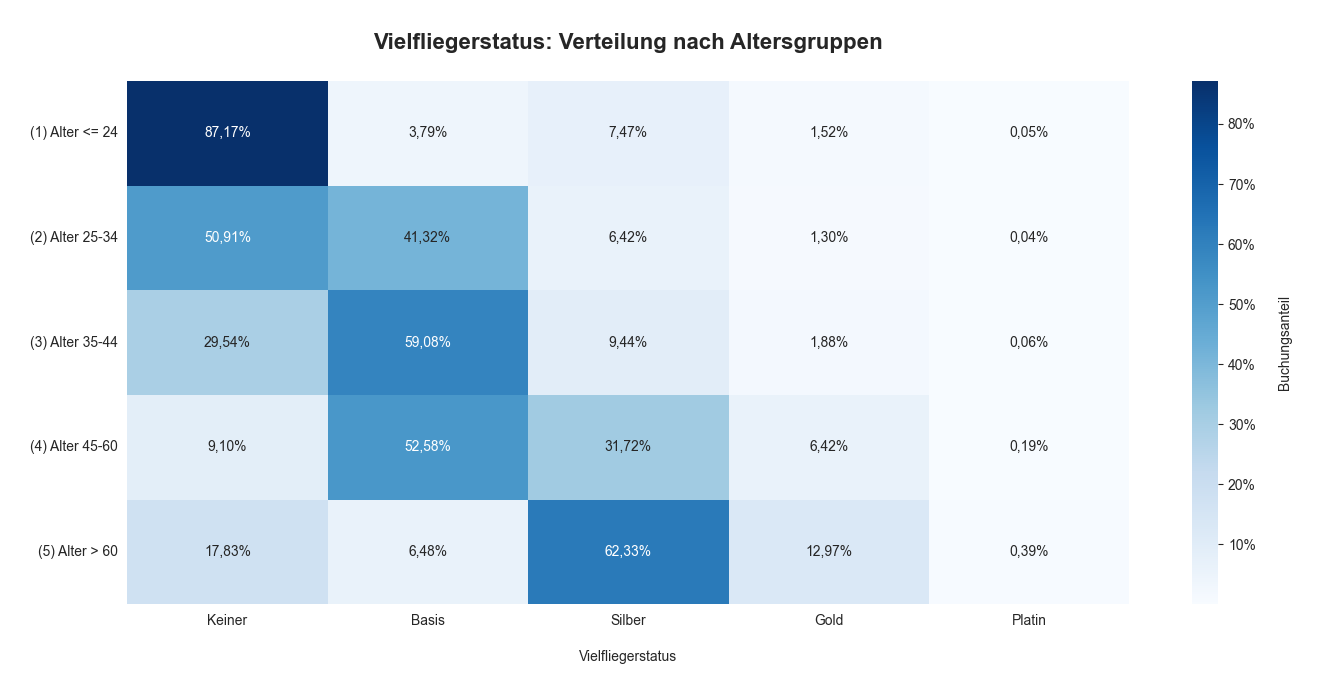

In [17]:
annotations_english = {
    "title": "Frequent Flyer Status Distribution by Age Groups",
    "x_label": "Frequent Flyer Status",
    "legend": "Share of Bookings",
    "y": "age_group",
    "file": "(15)_flyer_status_age"
}

annotations_german = {
    "title": "Vielfliegerstatus: Verteilung nach Altersgruppen",
    "x_label": "Vielfliegerstatus",
    "legend": "Buchungsanteil",
    "y": "age_group_ger",
    "file": "(15)_fliegerstatus_alter"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

freq_tier_heat_eng = (
    gender_age_stats.query("age_group != 'Unknown'").groupby(f"{annot["y"]}")[freq_tier_cols].mean().sort_index()
)

# Clean column labels
freq_tier_heat_eng.columns = [
    col.replace("_flyers_pct", "").replace("no_status", "None").replace("_status", "").replace("_", "").title()
    for col in freq_tier_heat_eng.columns
]

# localize
freq_tier_heat_ger = freq_tier_heat_eng.copy()
freq_tier_heat_ger.columns = [col.replace("None", "Keiner").replace("Basic", "Basis").replace("Silver", "Silber")
                              .replace("Platinum", "Platin")
                              for col in freq_tier_heat_ger.columns]

freq_tier_heat = [freq_tier_heat_ger if language_setting == "de" else freq_tier_heat_eng][0]

# Create formatted cell labels for annotations
cell_labels = freq_tier_heat.copy().map(
    lambda v_: locale.format_string("%.2f", v_, grouping=True) + "%" if pd.notna(v_) else ""
)

# Plot
plt.figure(figsize=(14, 7))
ax = sns.heatmap(
    freq_tier_heat,
    annot=cell_labels, fmt="", cmap="Blues",
    cbar_kws={"label": f"\n{annot["legend"]}\n"}
)

# format colorbar
ax.collections[0].colorbar.ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: locale.format_string("%.0f", x, grouping=True)+ "%")
)

plt.title(f"\n{annot["title"]}\n", fontsize=16, weight="bold")
plt.xlabel(f"\n{annot["x_label"]}\n")
plt.ylabel(" ")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()

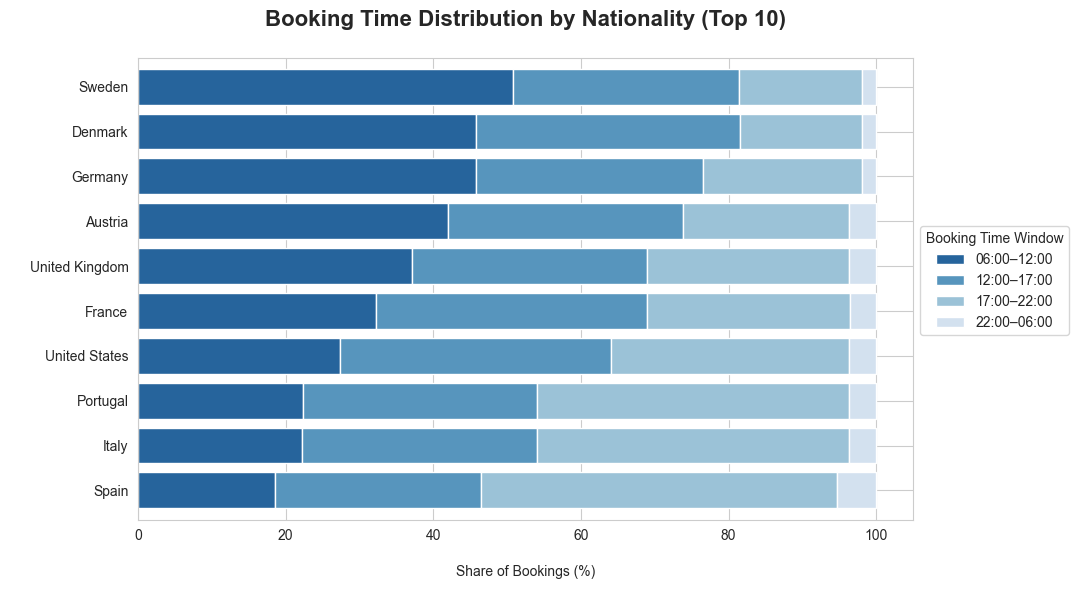

In [710]:
annotations_english = {
    "title": "Booking Time Distribution by Nationality (Top 10)",
    "x_label": "Share of Bookings (%)",
    "nat": "nationality",
    "legend": "Booking Time Window",
    "file": "(16)_booking_times"
}

annotations_german = {
    "title": "Verteilung von Buchungstageszeiten nach Nationalität (Top 10)",
    "x_label": "Buchungsanteil (%)",
    "nat": "nationality_ger",
    "legend": "Buchungszeitfenster",
    "file": "(16)_buchungszeiten"
}

annot = [annotations_german if language_setting == "de" else annotations_english][0]

top_n = nationality_stats.nlargest(10, "total_bookings")
top_n["nationality_ger"] = top_n["nationality"].map(nationalities_eng_ger)

time_cols = [
    "pct_bookings_btw_06_and_12",
    "pct_bookings_btw_12_and_17",
    "pct_bookings_btw_17_and_22",
    "pct_bookings_btw_22_and_06"
]

colors = [sns.desaturate(c, 0.8) for c in sns.color_palette("Blues_r", 4)]
top_n.set_index(annot["nat"])[time_cols].sort_values("pct_bookings_btw_06_and_12").plot(
    kind="barh", stacked=True, figsize=(10, 6), width=0.8, color=colors
)

plt.title(f"{annot["title"]}\n", fontsize=16, fontweight="bold")
plt.xlabel(f"\n{annot["x_label"]}")
plt.ylabel(" ")
plt.legend(["06:00–12:00", "12:00–17:00", "17:00–22:00", "22:00–06:00"], title=annot["legend"], bbox_to_anchor=(1.0, 0.65))
plt.savefig(path + annot["file"] + ".png", dpi=300, bbox_inches="tight")
plt.show()